# Student Performance Factors

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, r2_score,explained_variance_score
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

# Functions

In [2]:
def check_nulls_dupes(df):
  print(f"Number of Nulls: {df.isna().sum()}")
  print(f"Number of Duplicates: {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()

def plot_distribution(df, dist_type):
  
  plt.figure(figsize=(16, 16))
  rows = len(df.columns)
  dims = (rows+ 4)//3
  
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if dist_type == "hist" else sns.boxplot(df[col])
    plt.title(f"Distirbution of {col}") if dist_type == "hist" else plt.title(f"Boxplot of {col}")
  plt.tight_layout()
  plt.show()

def create_preprocessor(numeric_cols, categorical_cols):
  
  numeric_transformer = Pipeline(
    steps=[
      ("Scaler", MinMaxScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  categorical_transformer = Pipeline(
    steps=[
      ("Encoder", OneHotEncoder())
    ]
  )
  
  return ColumnTransformer(
    transformers = [
      ("Categorical", categorical_transformer, categorical_cols),
      ("Numeric", numeric_transformer, numeric_cols)
    ]
  )

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def mapping_function(val):
  grade = None
  if val >=90:
    grade = "A"
  elif val >= 80 and val <=90:
    grade = "B"
  elif val>= 70 and val <=79:
    grade = "C"
  elif val >=60 and val<=69:
    grade = "D"
  else:
    grade = "F"

  return grade

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def create_sklearn_pipeline(preprocessor, model, kbest=None):
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append({
      "Component":component,
      "CumSum": cumsum
    })
  
  df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(20, 12))
  plt.title("PCA Analysis")
  plt.xlabel("Component")
  plt.ylabel("CumSum")
  sns.barplot(data=df, x="Component", y="CumSum")
  plt.show()
  return df

def get_selected_models(names):
  models = {
        "SVR": SVR(),
        "LR": LinearRegression(),
        "KNN": KNeighborsRegressor(),
        "GBR": GradientBoostingRegressor(),
        "RFR": RandomForestRegressor(),
        "XGB": XGBRegressor(),
        "LASSO": Lasso(),
        "RIDGE": Ridge(),
        "CAT":CatBoostRegressor(verbose=0),
        "DUMMY": DummyRegressor(strategy="mean")
    }
    
  return [models[model] for model in names]


def get_metrics(y, predictions):
    mae = mean_absolute_error(y, predictions)
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mean_squared_error(y, predictions))
    r2 = r2_score(y, predictions)
    exp = explained_variance_score(y, predictions)
    
    return [mae, mse, rmse, r2, exp]

def evaluate_model(model, X, y, metric):
    cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
    preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
    mae, mse, rmse, r2, exp = get_metrics(y, preds)
    
    return [
        round(np.mean(scores), 3), 
        round(np.var(scores), 3), 
        round(np.std(scores), 3), 
        round(mae, 3), 
        round(mse, 3),
        round(np.sqrt(rmse), 3),
        round(r2, 3),
        round(exp, 3)
    ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, kbest=None):
    metric_tracker = []
    
    for model, model_name in zip(models, model_names):
        pipeline = create_sklearn_pipeline(preprocessor, model, kbest) if kbest else create_sklearn_pipeline(preprocessor,model) 
        scores = evaluate_model(pipeline, X, y, scoring_metric)
        metric_tracker.append({
            "Model": model_name,
            "Mean": scores[0],
            "Var": scores[1],
            "STD": scores[2],
            "MAE": scores[3],
            "MSE": scores[4],
            "RMSE": scores[5],
            "R2": scores[6],
            "Explained Var": scores[7]
        })
    
    return pd.DataFrame(metric_tracker).sort_values(by="RMSE", ascending=True)

def test_kbest_columns(preprocessor ,X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(preprocessor, model, metric)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)

    metric_tracker.append({
            "Model": model_name,
            'K':k,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
    
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  metric_tracker = []
  best_models = []
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline(preprocessor, model, kbest)

    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)
    best_models.append(best_model)
    print(f"The Best Param: {best_params} for Model: {model_name}")
    metric_tracker.append({
            "Model": model_name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
  
  return [pd.DataFrame(metric_tracker).sort_values(by="RMSE", ascending=True), best_models]

def residual_plot(models, model_names, X, y):
  
  
  for model, model_name in zip(models, model_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    residuals = y_test - predictions

    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.title(f'Residual Plot for {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    plt.show()
    
    plt.scatter(y_test, predictions)
    plt.show()

def get_feature_names(column_transformer):
    """Get feature names from all transformers in ColumnTransformer."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'named_steps'): 
                if 'Encoder' in pipe.named_steps: 
                    feature_names = pipe.named_steps['Encoder'].get_feature_names_out(features)
                    output_features.extend(feature_names)
                else:
                    output_features.extend(features)
            else:
                output_features.extend(features)
        else:
            output_features.extend(features)
    return output_features

def voting_regressor(model, X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  metric_tracker = []
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
    
  mae, mse, rmse, r2, exp = get_metrics(y_test, y_pred)

  metric_tracker.append({
            "Model": "voting",
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
            "Explained Var": exp
        })
    
  return pd.DataFrame(metric_tracker)


# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0                23          84                  Low                High   
1                19          64                  Low              Medium   
2                24          98               Medium              Medium   
3                29          89                  Low              Medium   
4                19          92               Medium              Medium   
...             ...         ...                  ...                 ...   
6602             25          69                 High              Medium   
6603             23          76                 High              Medium   
6604             20          90               Medium                 Low   
6605             10          86                 High                High   
6606             15          67               Medium                 Low   

     Extracurricular_Activities  Sleep_Hours  Previous_Scores  \
0                            No            7               73   
1                            No            8               59   
2                           Yes            7               91   
3                           Yes            8               98   
4                           Yes            6               65   
...                         ...          ...              ...   
6602                         No            7               76   
6603                         No            8               81   
6604                        Yes            6               65   
6605                        Yes            6               91   
6606                        Yes            9               94   

     Motivation_Level Internet_Access  Tutoring_Sessions Family_Income  \
0                 Low             Yes                  0           Low   
1                 Low             Yes                  2        Medium   
2              Medium             Yes                  2        Medium   
3              Medium             Yes                  1        Medium   
4              Medium             Yes                  3        Medium   
...               ...             ...                ...           ...   
6602           Medium             Yes                  1          High   
6603           Medium             Yes                  3           Low   
6604              Low             Yes                  3           Low   
6605             High             Yes                  2           Low   
6606           Medium             Yes                  0        Medium   

     Teacher_Quality School_Type Peer_Influence  Physical_Activity  \
0             Medium      Public       Positive                  3   
1             Medium      Public       Negative                  4   
2             Medium      Public        Neutral                  4   
3             Medium      Public       Negative                  4   
4               High      Public        Neutral                  4   
...              ...         ...            ...                ...   
6602          Medium      Public       Positive                  2   
6603            High      Public       Positive                  2   
6604          Medium      Public       Negative                  2   
6605          Medium     Private       Positive                  3   
6606          Medium      Public       Positive                  4   

     Learning_Disabilities Parental_Education_Level Distance_from_Home  \
0                       No              High School               Near   
1                       No                  College           Moderate   
2                       No             Postgraduate               Near   
3                       No              High School           Moderate   
4                       No                  College               Near   
...                    ...                      ...                ...   
6602                    No              High School             

In [4]:
df.dtypes

Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

In [5]:
df.describe()

Hours_Studied   Attendance  Sleep_Hours  Previous_Scores  \
count    6607.000000  6607.000000   6607.00000      6607.000000   
mean       19.975329    79.977448      7.02906        75.070531   
std         5.990594    11.547475      1.46812        14.399784   
min         1.000000    60.000000      4.00000        50.000000   
25%        16.000000    70.000000      6.00000        63.000000   
50%        20.000000    80.000000      7.00000        75.000000   
75%        24.000000    90.000000      8.00000        88.000000   
max        44.000000   100.000000     10.00000       100.000000   

       Tutoring_Sessions  Physical_Activity   Exam_Score  
count        6607.000000        6607.000000  6607.000000  
mean            1.493719           2.967610    67.235659  
std             1.230570           1.031231     3.890456  
min             0.000000           0.000000    55.000000  
25%             1.000000           2.000000    65.000000  
50%             1.000000           3.000000    67.000000  
75%             2.000000           4.000000    69.000000  
max             8.000000           6.000000   101.000000

# Nulls & Dupes

In [6]:
check_nulls_dupes(df)

Number of Nulls: Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64
Number of Duplicates: 0


In [7]:
df.dropna(inplace=True)

# Separate Categorical and Continuous variables

In [8]:
categorical_types = df.select_dtypes(include="object")
numeric_types = df.select_dtypes(exclude="object")

Parental_Involvement


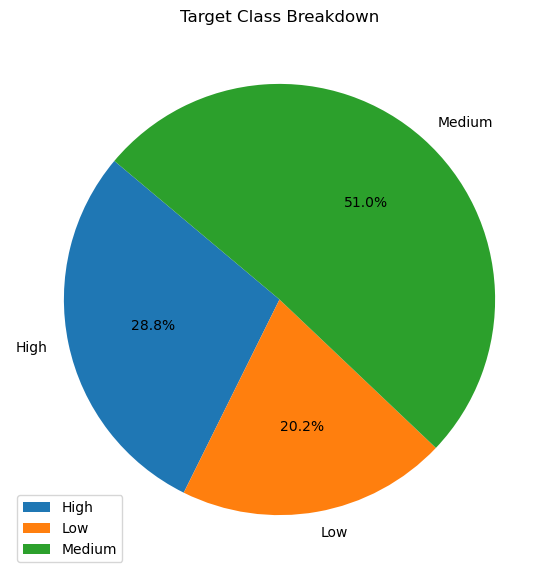

Access_to_Resources


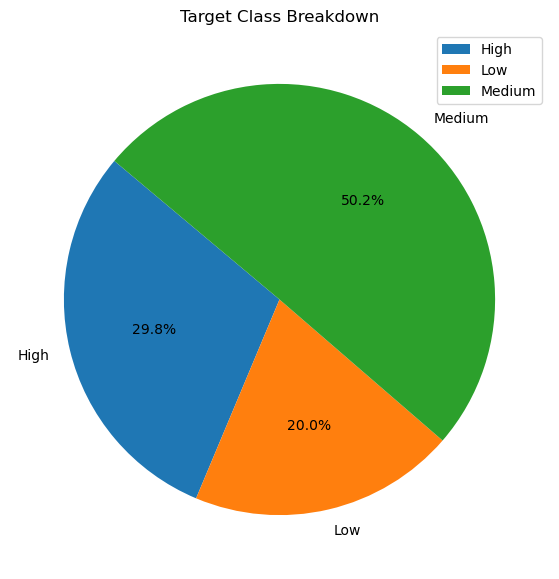

Extracurricular_Activities


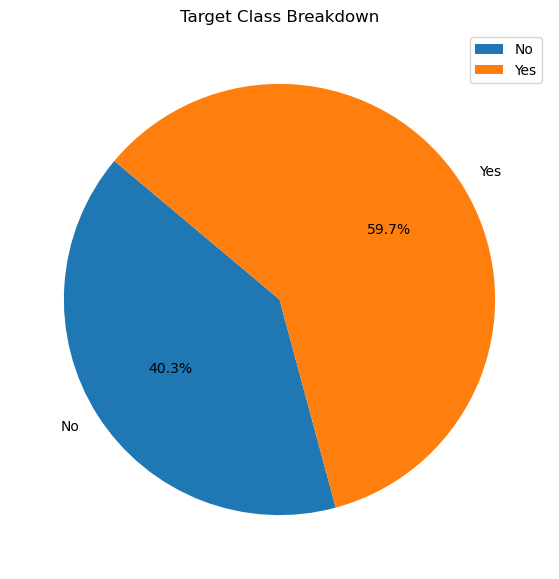

Motivation_Level


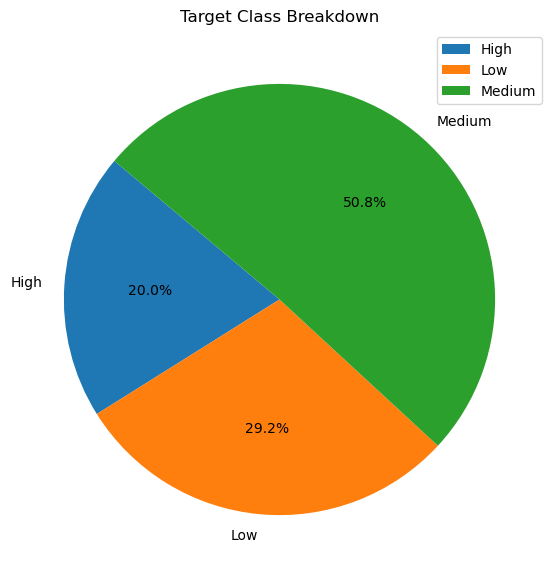

Internet_Access


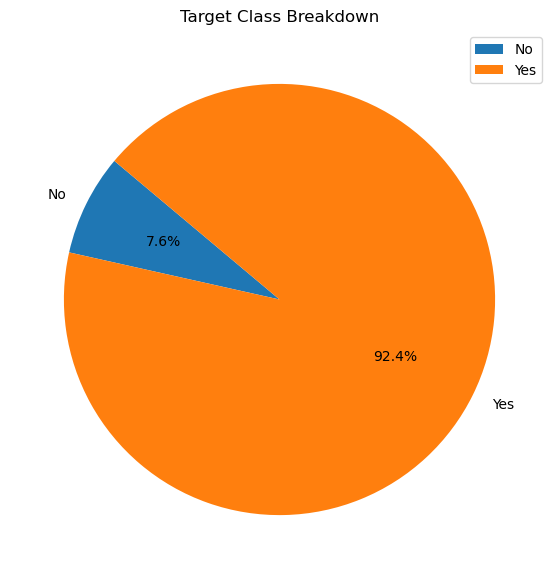

Family_Income


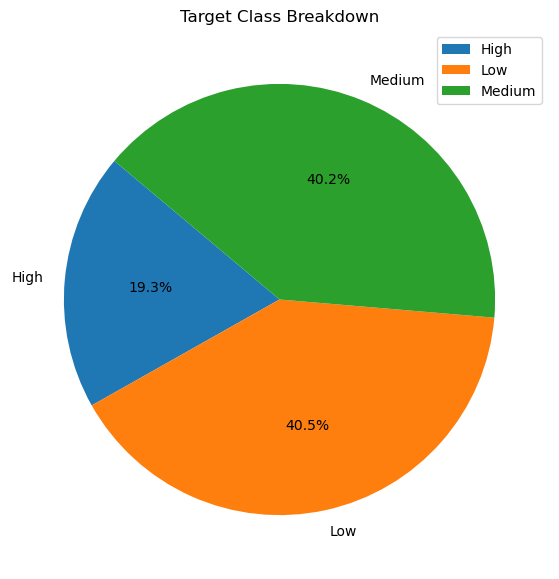

Teacher_Quality


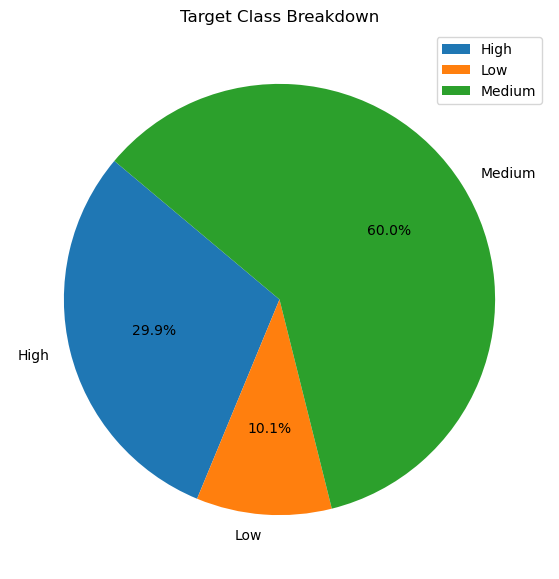

School_Type


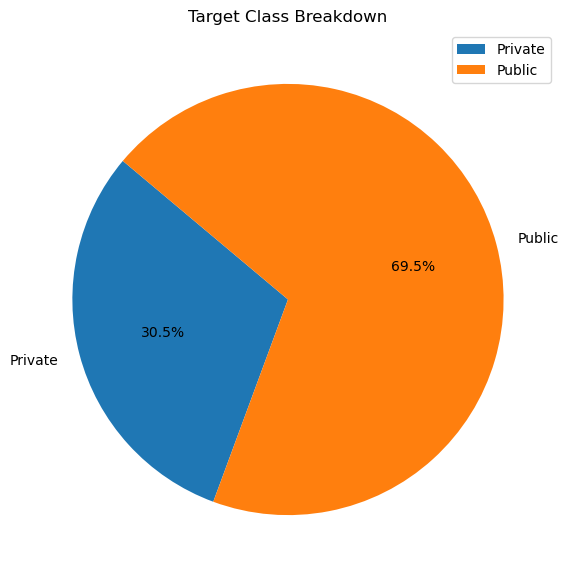

Peer_Influence


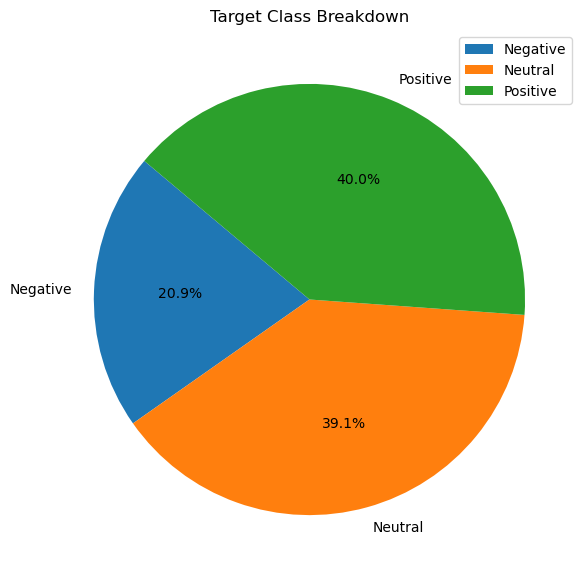

Learning_Disabilities


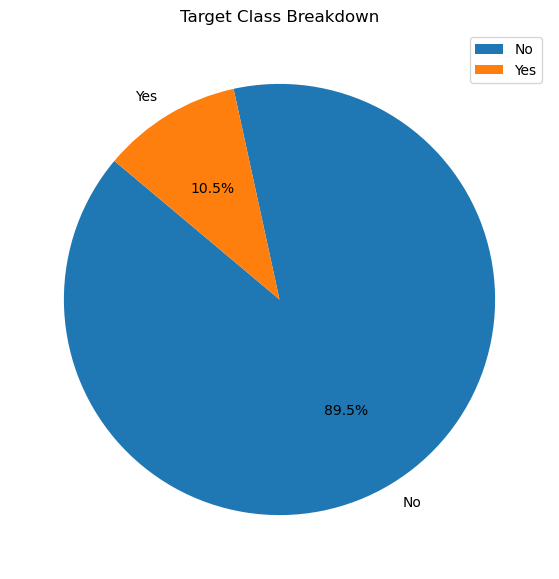

Parental_Education_Level


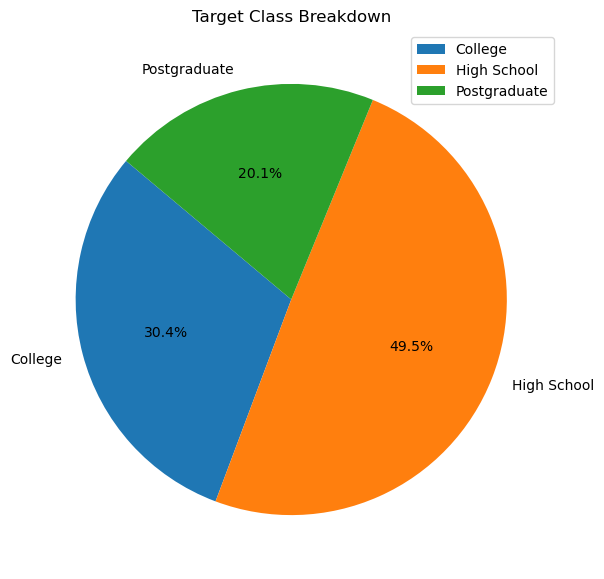

Distance_from_Home


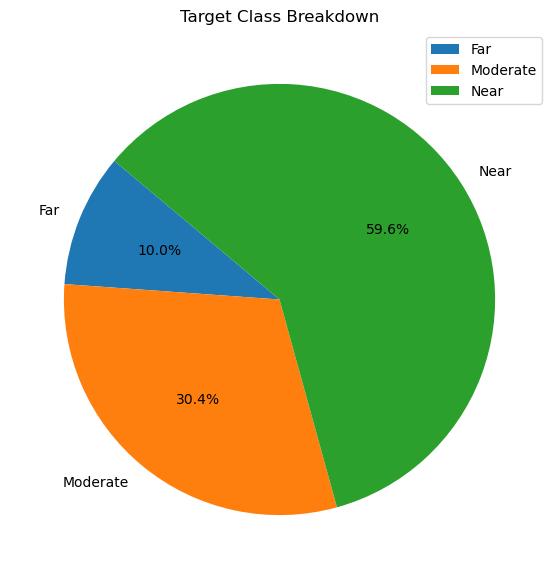

Gender


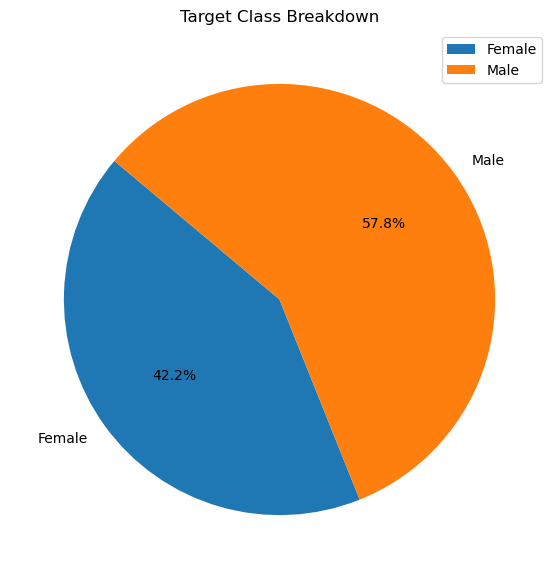

In [9]:
for col in categorical_types.columns:
  print(f"{col}")
  check_class_imbalance(categorical_types[col])

In [10]:
categorical_types

Parental_Involvement Access_to_Resources Extracurricular_Activities  \
0                     Low                High                         No   
1                     Low              Medium                         No   
2                  Medium              Medium                        Yes   
3                     Low              Medium                        Yes   
4                  Medium              Medium                        Yes   
...                   ...                 ...                        ...   
6602                 High              Medium                         No   
6603                 High              Medium                         No   
6604               Medium                 Low                        Yes   
6605                 High                High                        Yes   
6606               Medium                 Low                        Yes   

     Motivation_Level Internet_Access Family_Income Teacher_Quality  \
0                 Low             Yes           Low          Medium   
1                 Low             Yes        Medium          Medium   
2              Medium             Yes        Medium          Medium   
3              Medium             Yes        Medium          Medium   
4              Medium             Yes        Medium            High   
...               ...             ...           ...             ...   
6602           Medium             Yes          High          Medium   
6603           Medium             Yes           Low            High   
6604              Low             Yes           Low          Medium   
6605             High             Yes           Low          Medium   
6606           Medium             Yes        Medium          Medium   

     School_Type Peer_Influence Learning_Disabilities  \
0         Public       Positive                    No   
1         Public       Negative                    No   
2         Public        Neutral                    No   
3         Public       Negative                    No   
4         Public        Neutral                    No   
...          ...            ...                   ...   
6602      Public       Positive                    No   
6603      Public       Positive                    No   
6604      Public       Negative                    No   
6605     Private       Positive                    No   
6606      Public       Positive                    No   

     Parental_Education_Level Distance_from_Home  Gender  
0                 High School               Near    Male  
1                     College           Moderate  Female  
2                Postgraduate               Near    Male  
3                 High School           Moderate    Male  
4                     College               Near  Female  
...                       ...                ...     ...  
6602              High School               Near  Female  
6603              High School               Near  Female  
6604             Postgraduate               Near  Female  
6605              High School                Far  Female  
6606             Postgraduate               Near    Male  

[6378 rows x 13 columns]

# Histogram

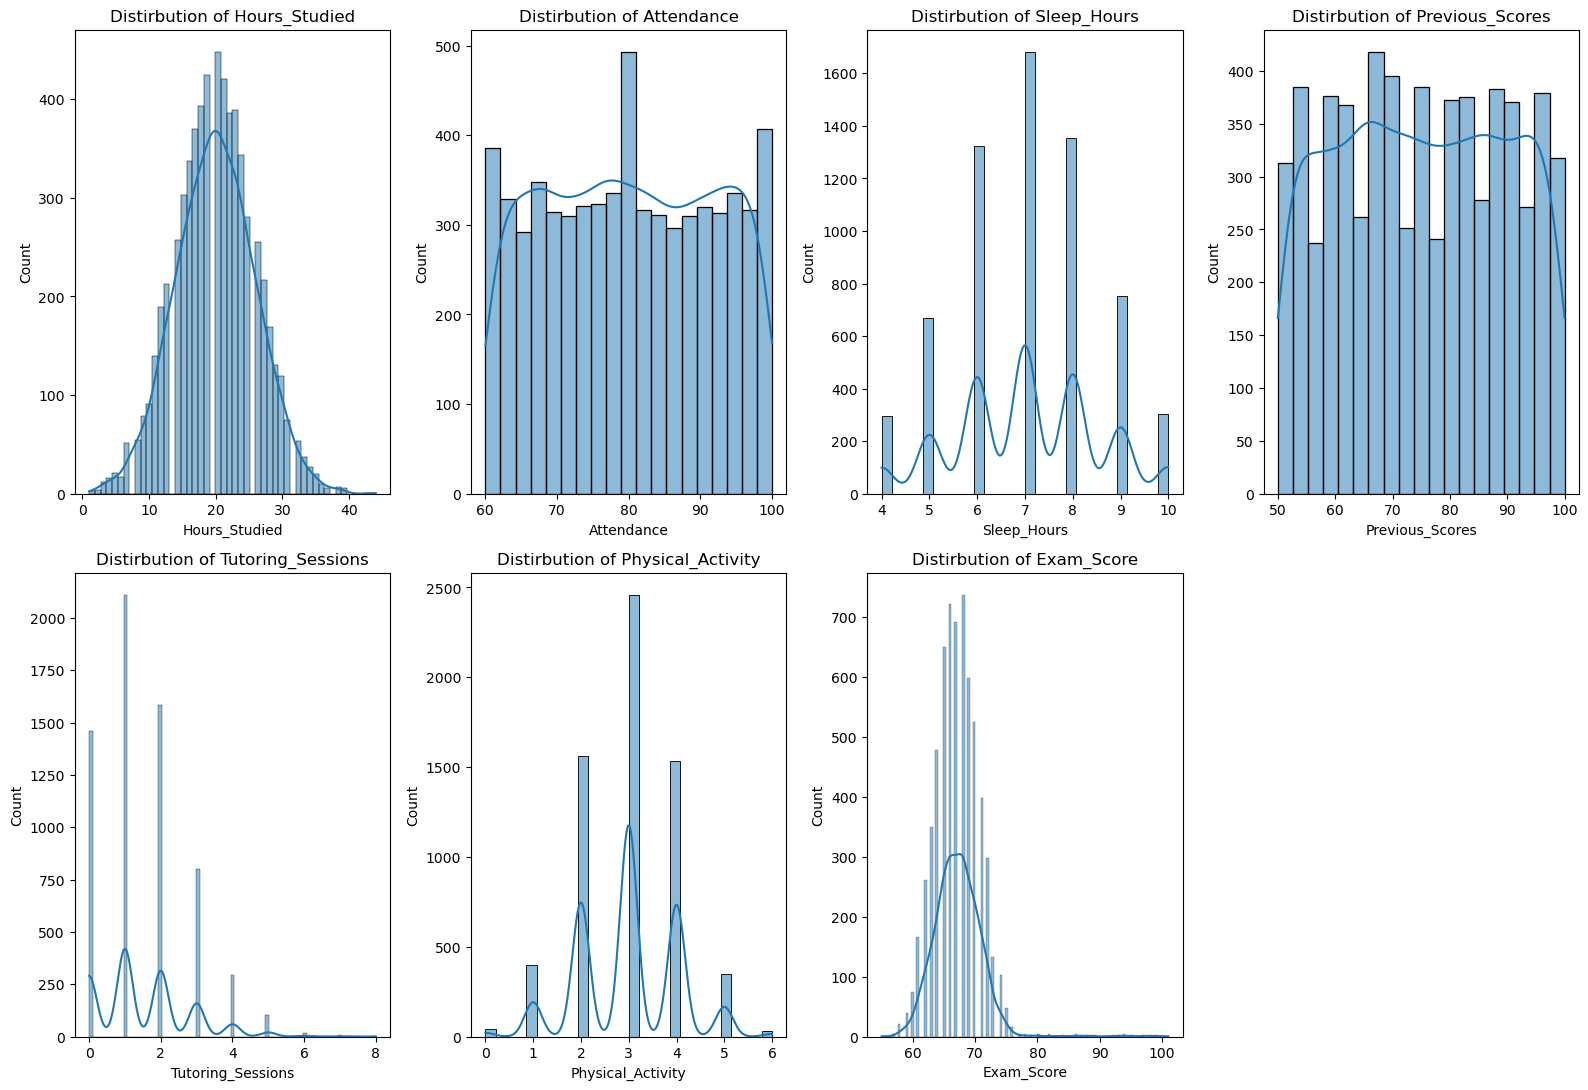

In [11]:
plot_distribution(numeric_types, "hist")

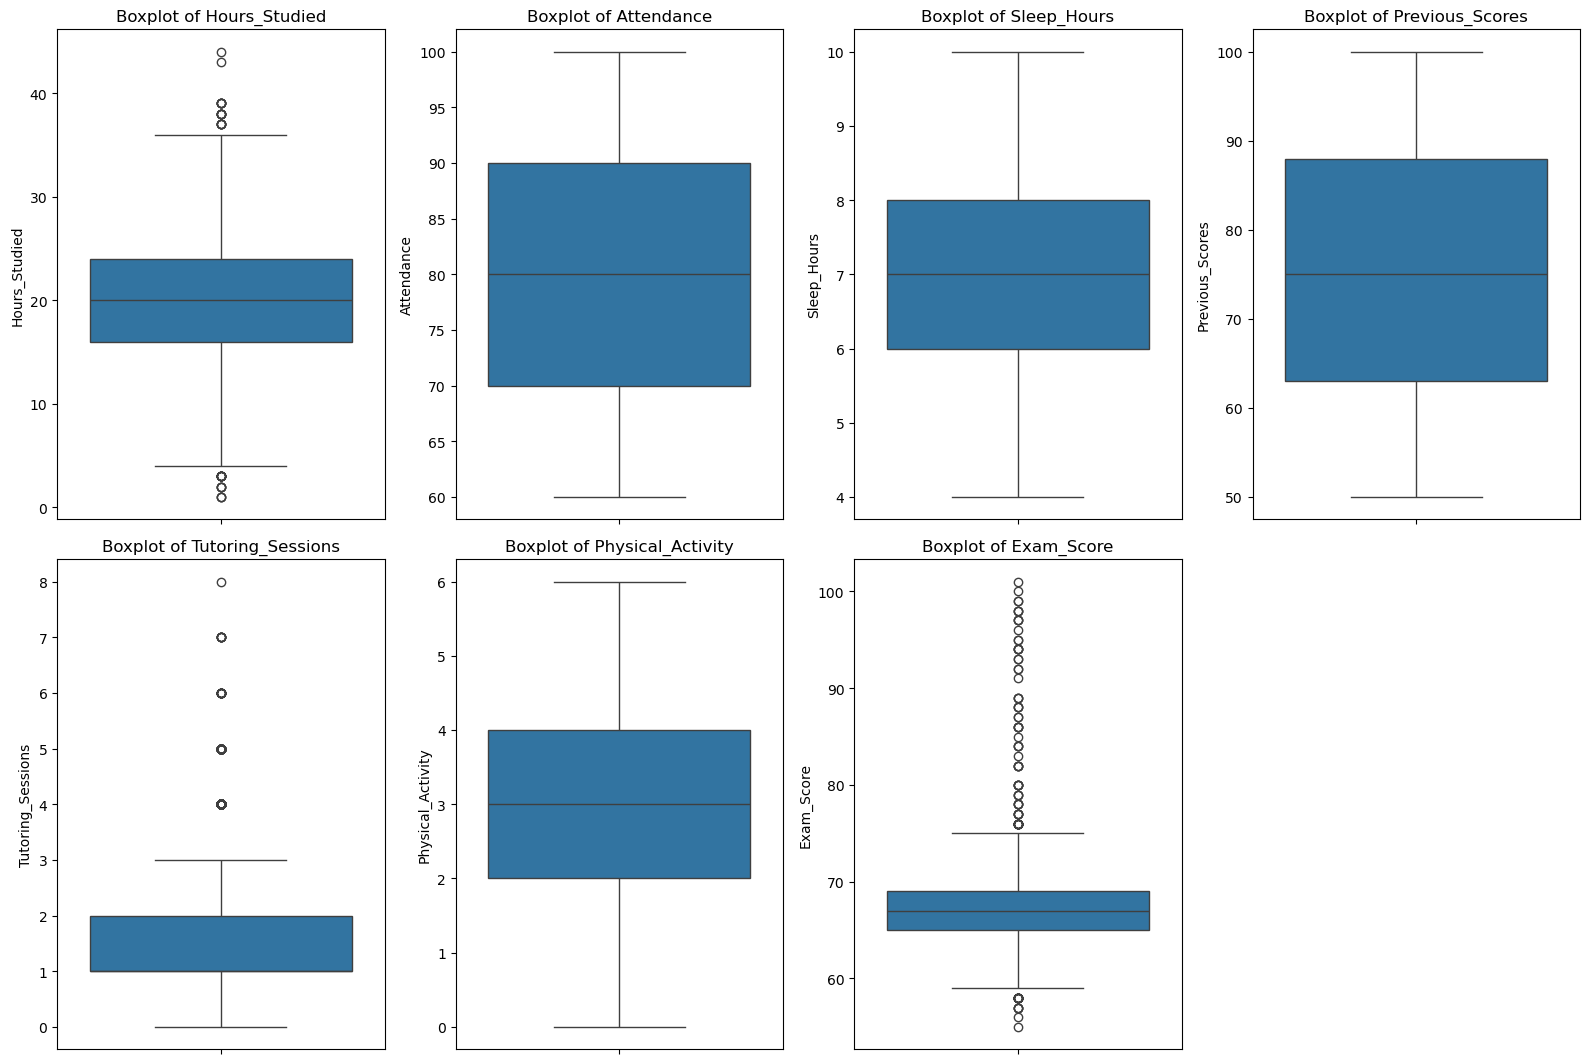

In [12]:
plot_distribution(numeric_types, "box")

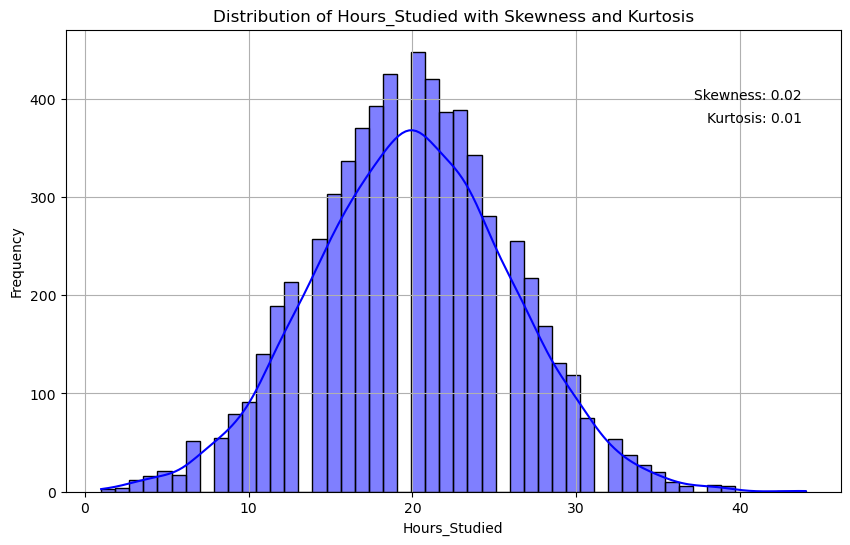

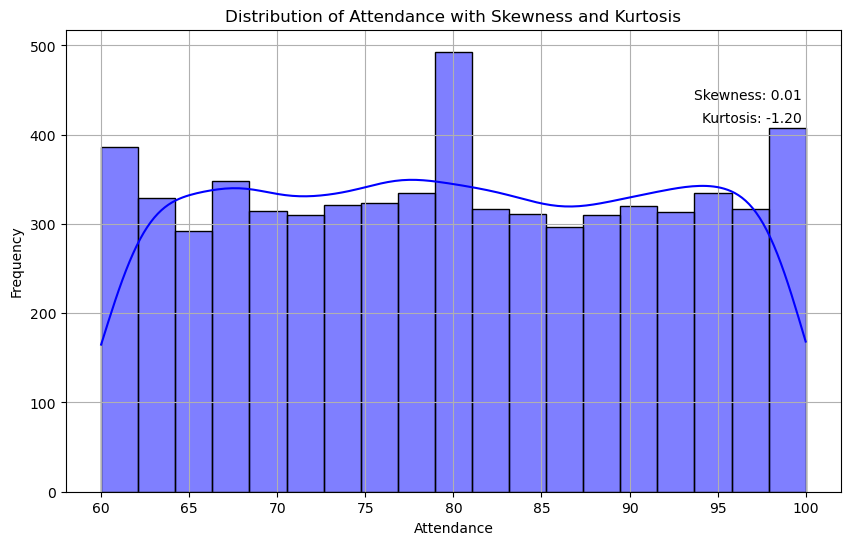

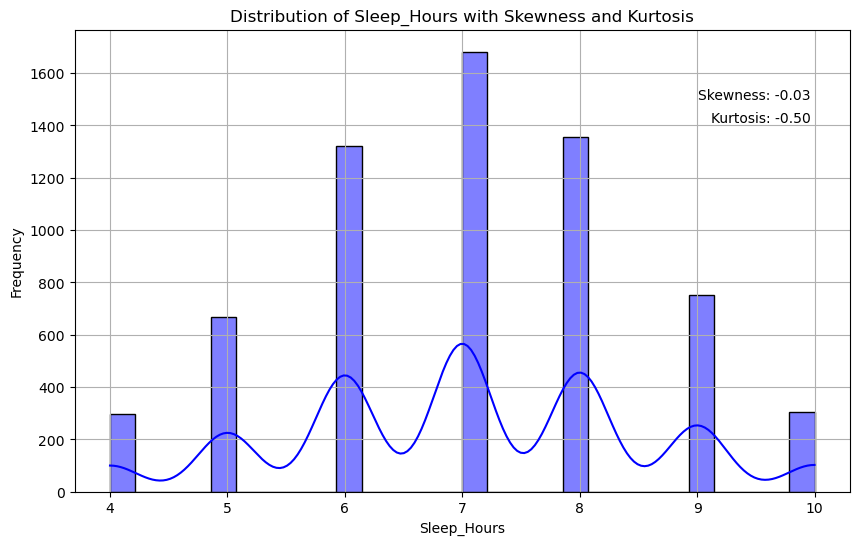

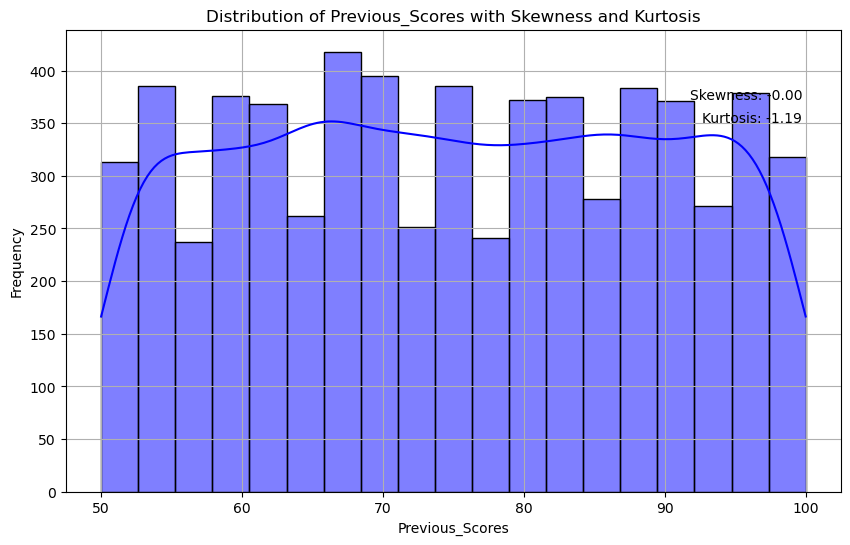

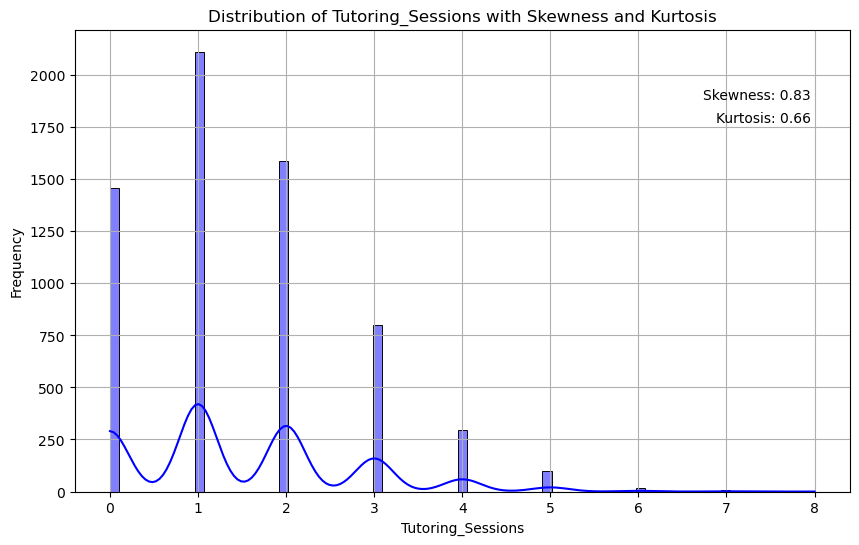

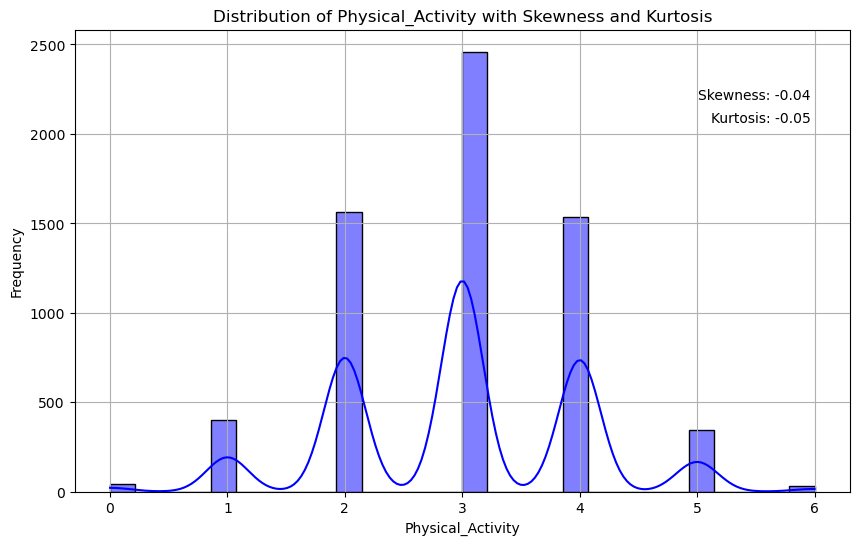

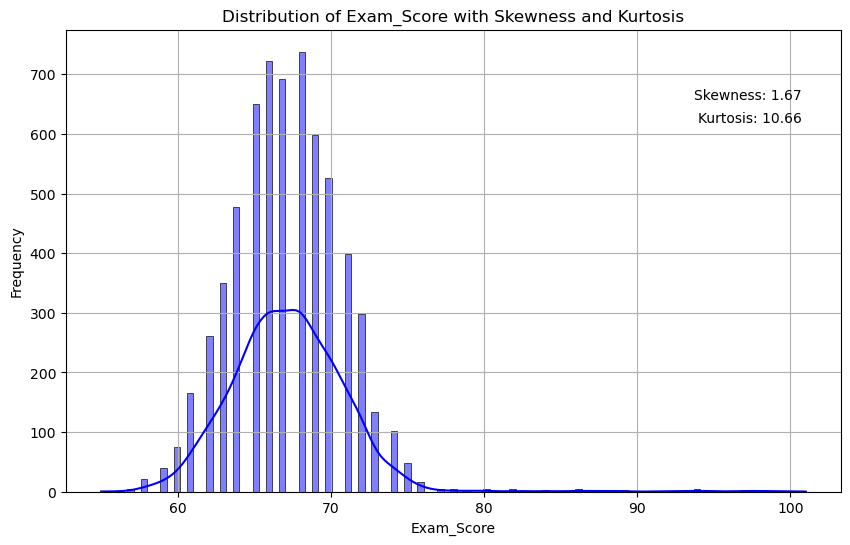

In [13]:
dist_plot(numeric_types)

# Aggregated Views

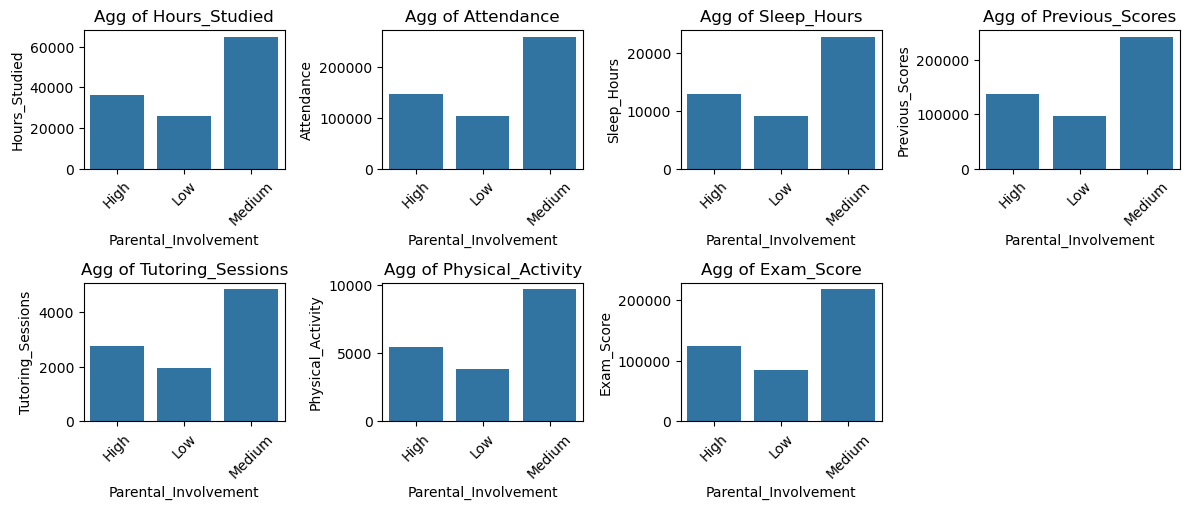

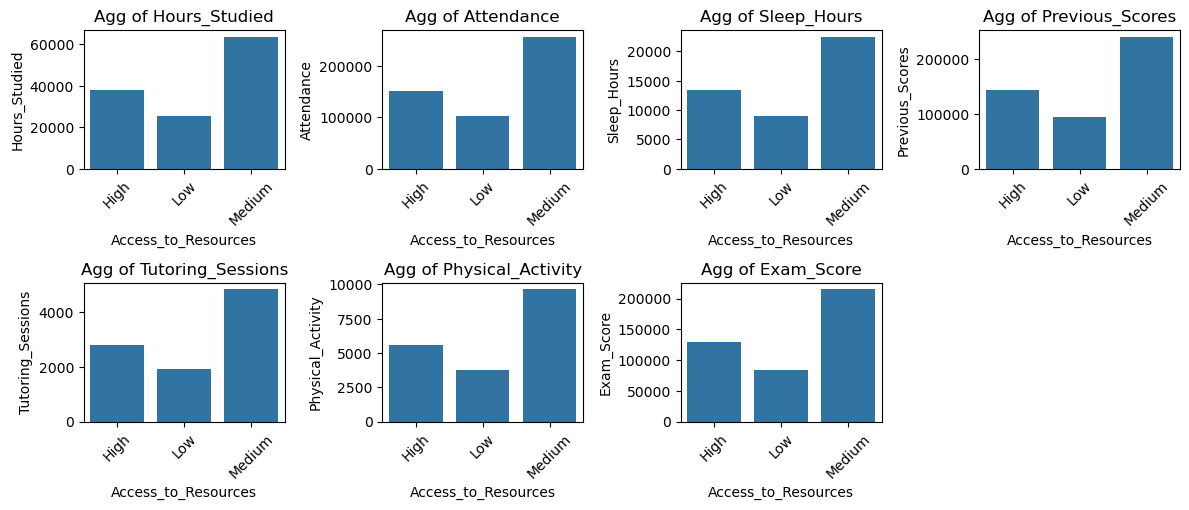

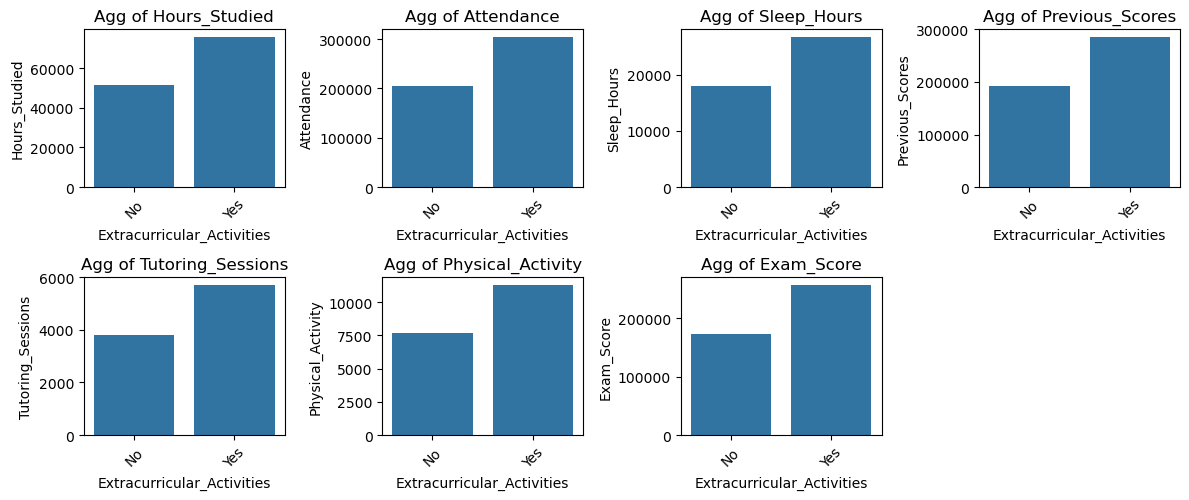

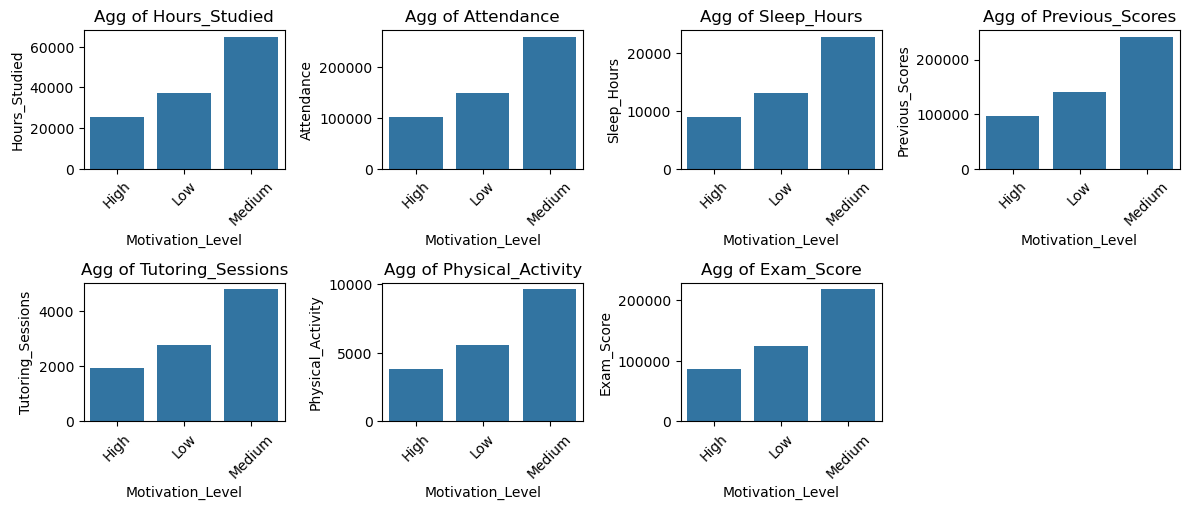

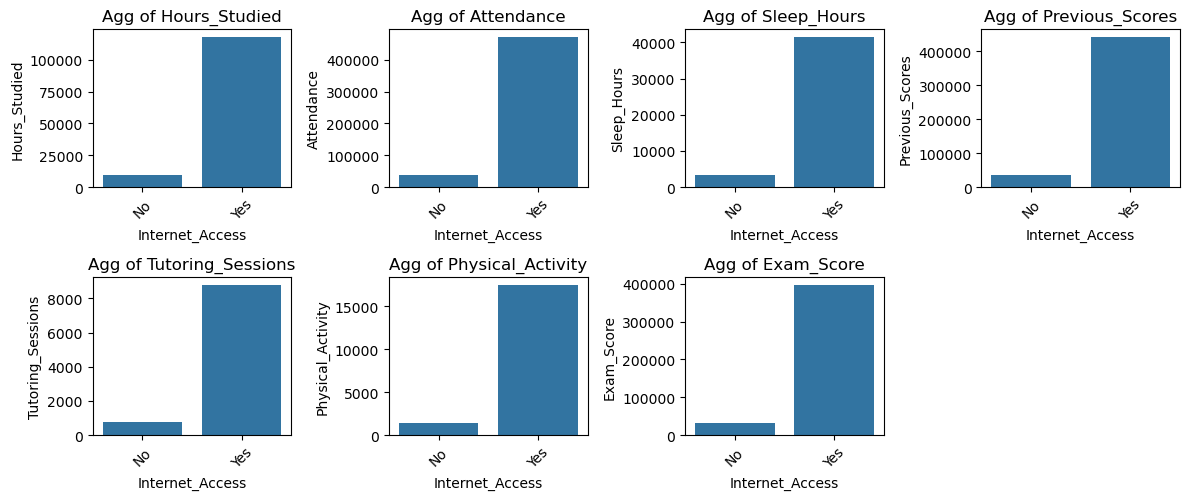

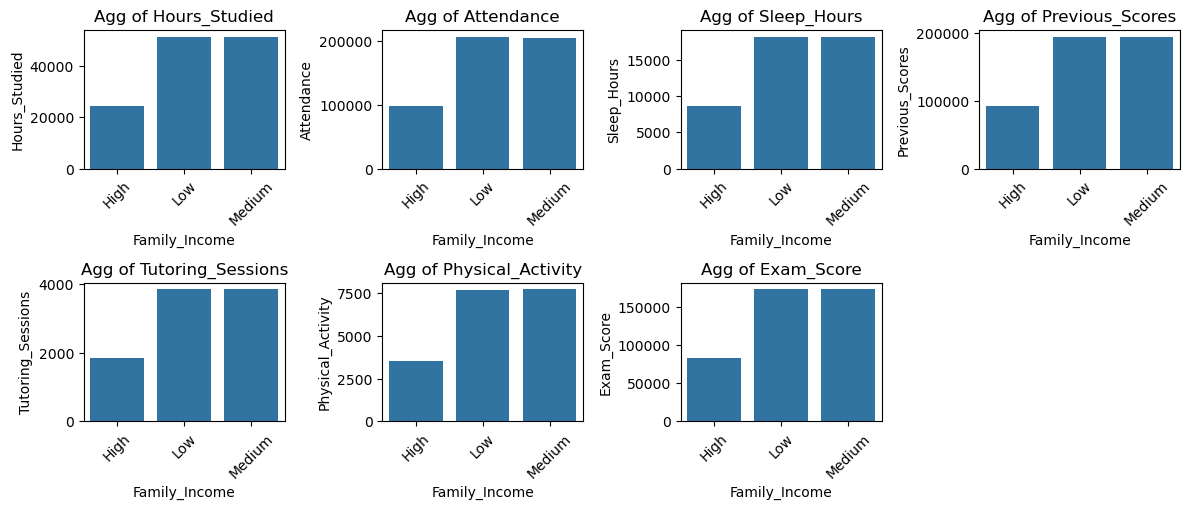

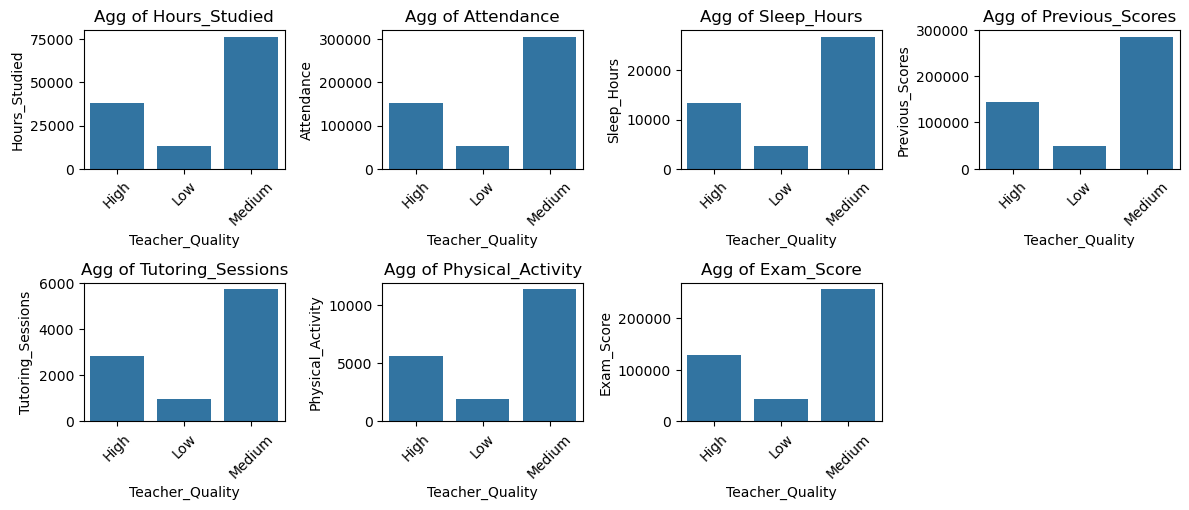

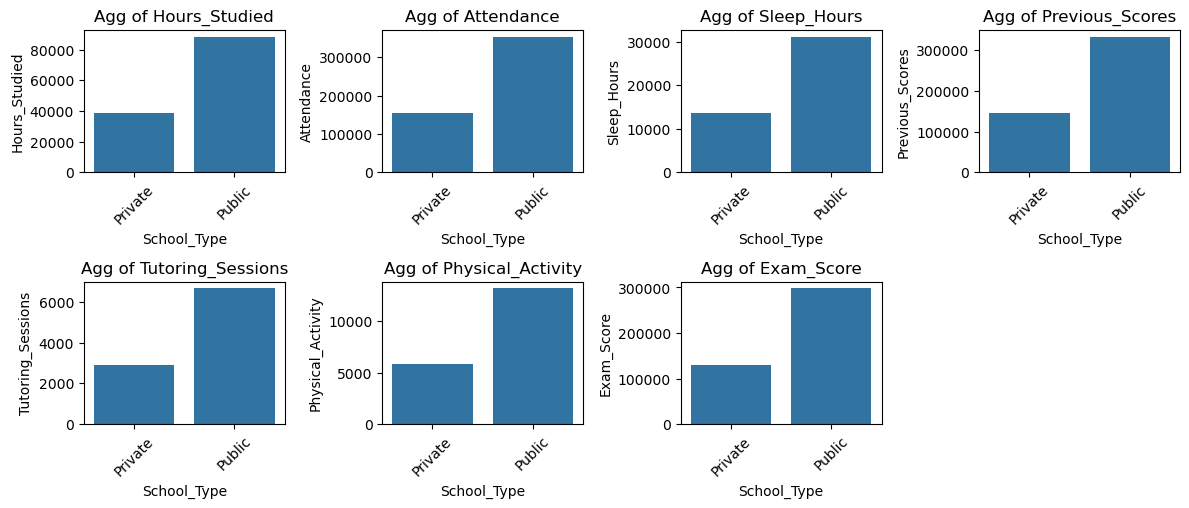

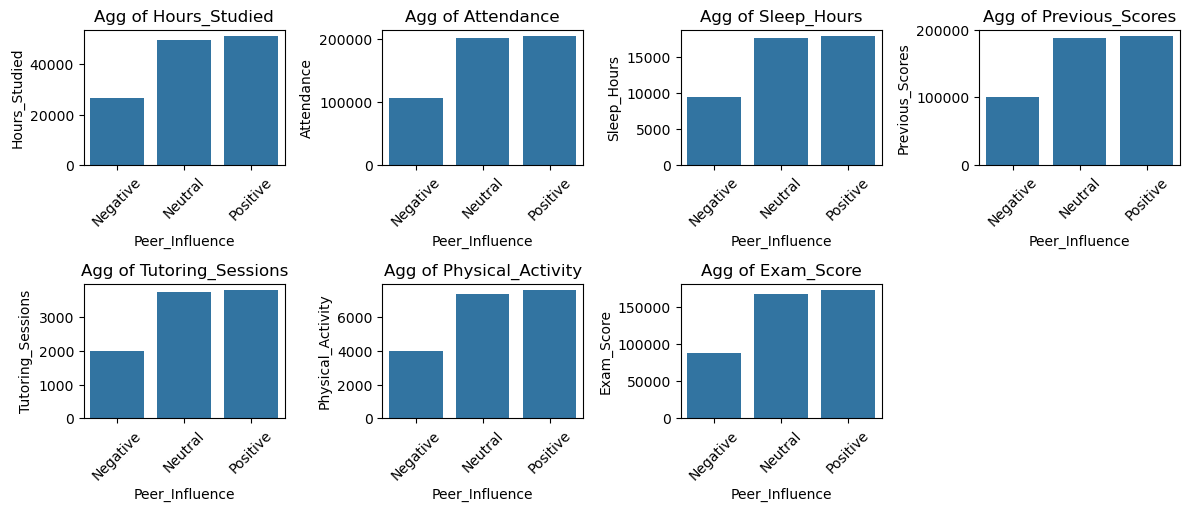

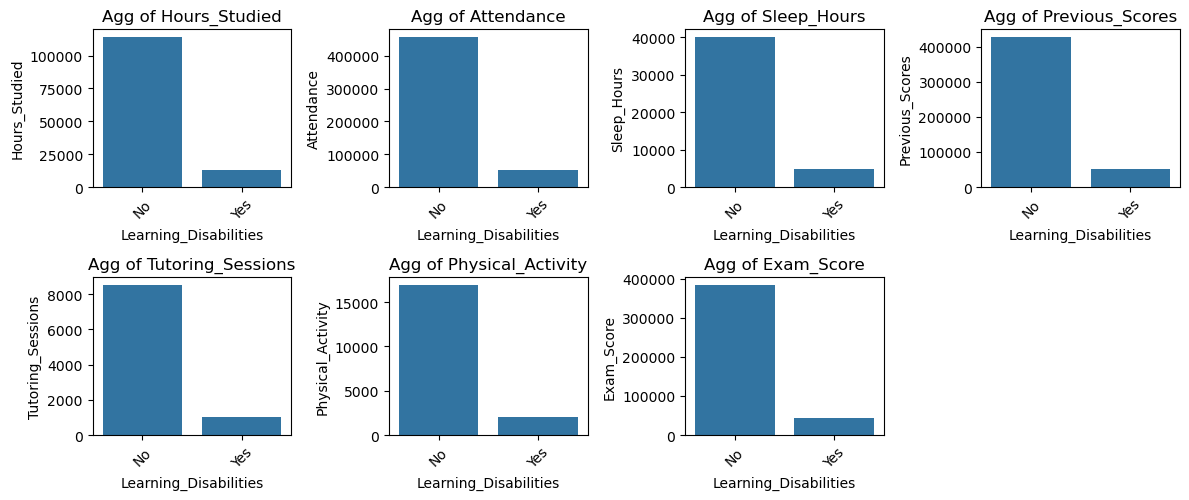

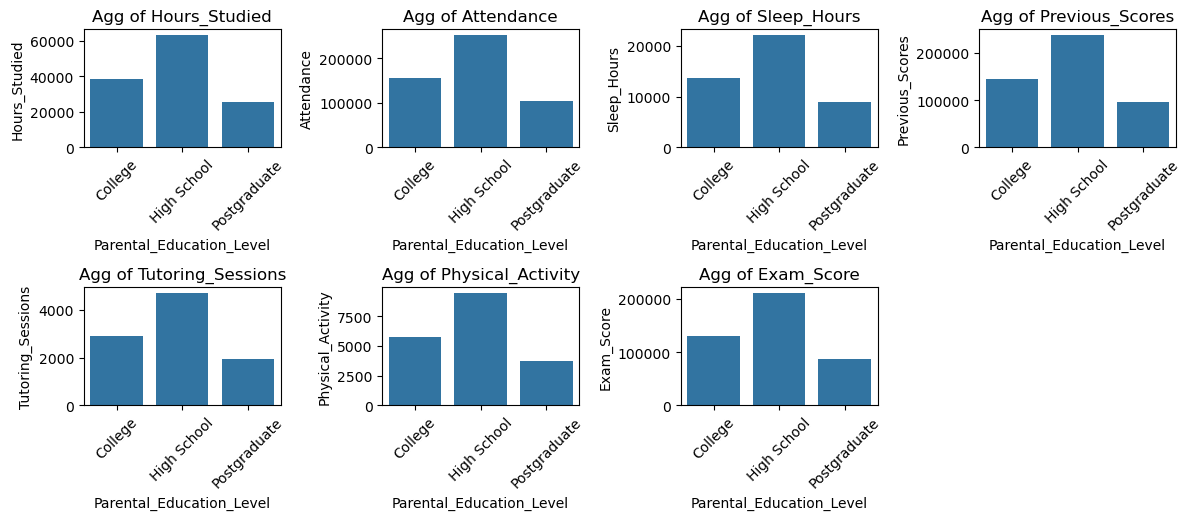

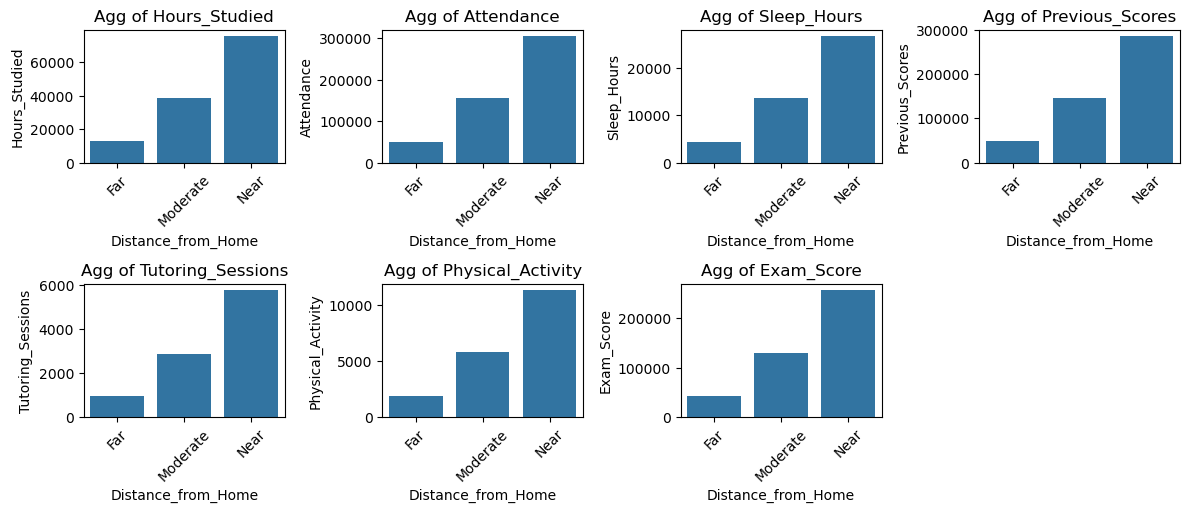

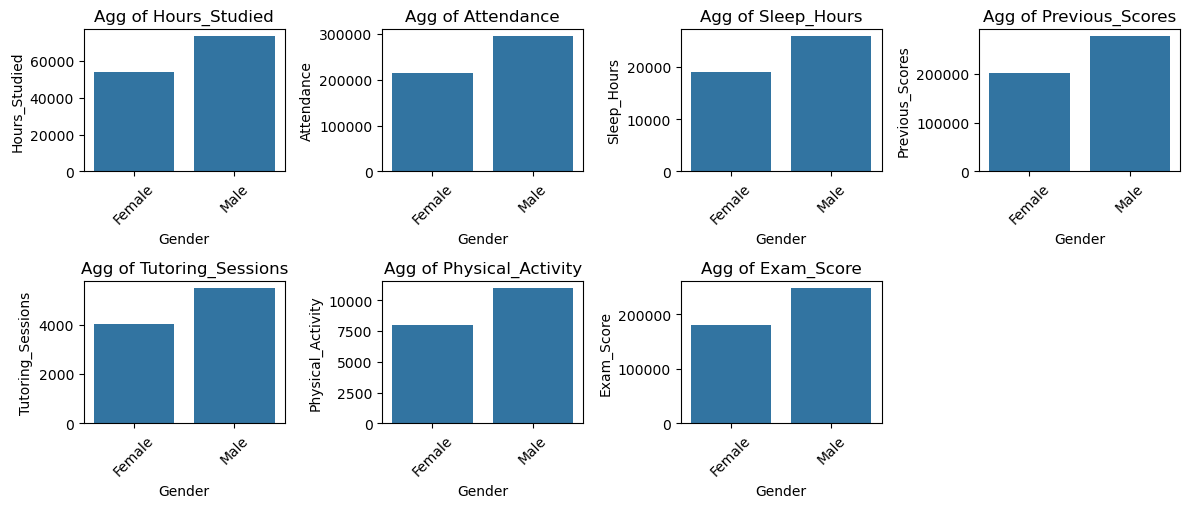

In [14]:
for col in categorical_types.columns:
  aggregate_dataset(df,numeric_types.columns, col, "sum")

# Scatter Plots

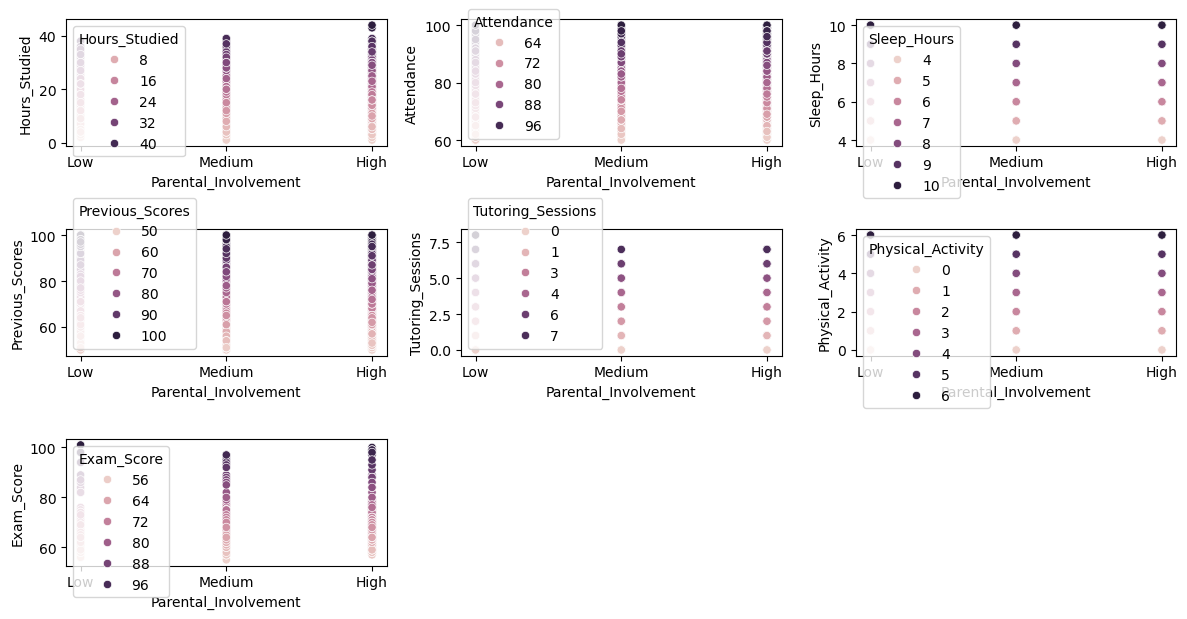

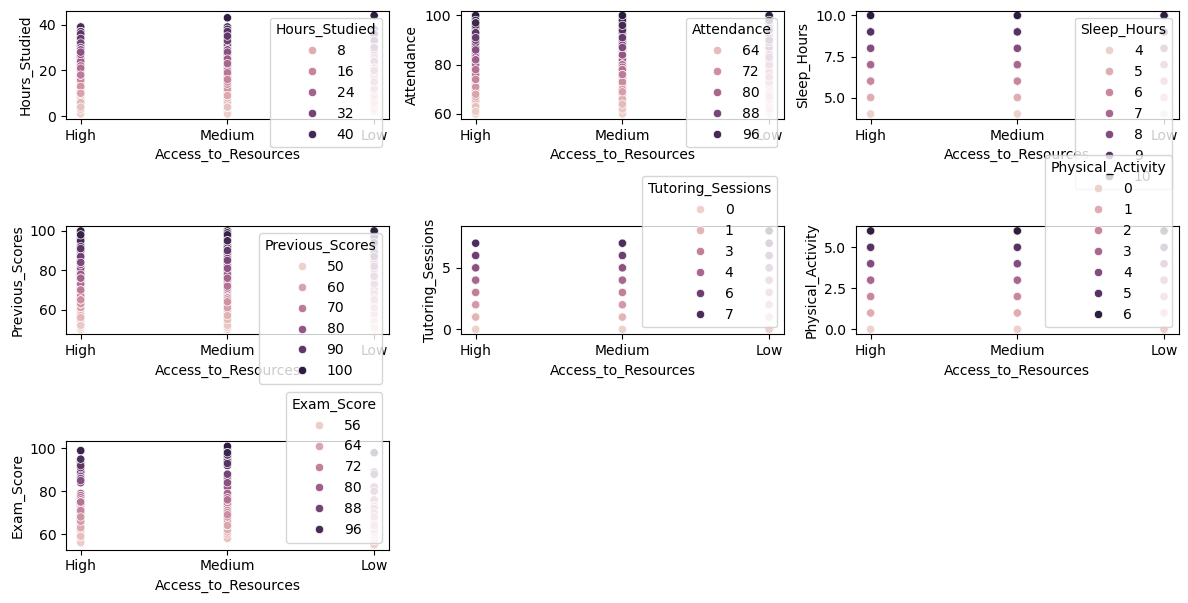

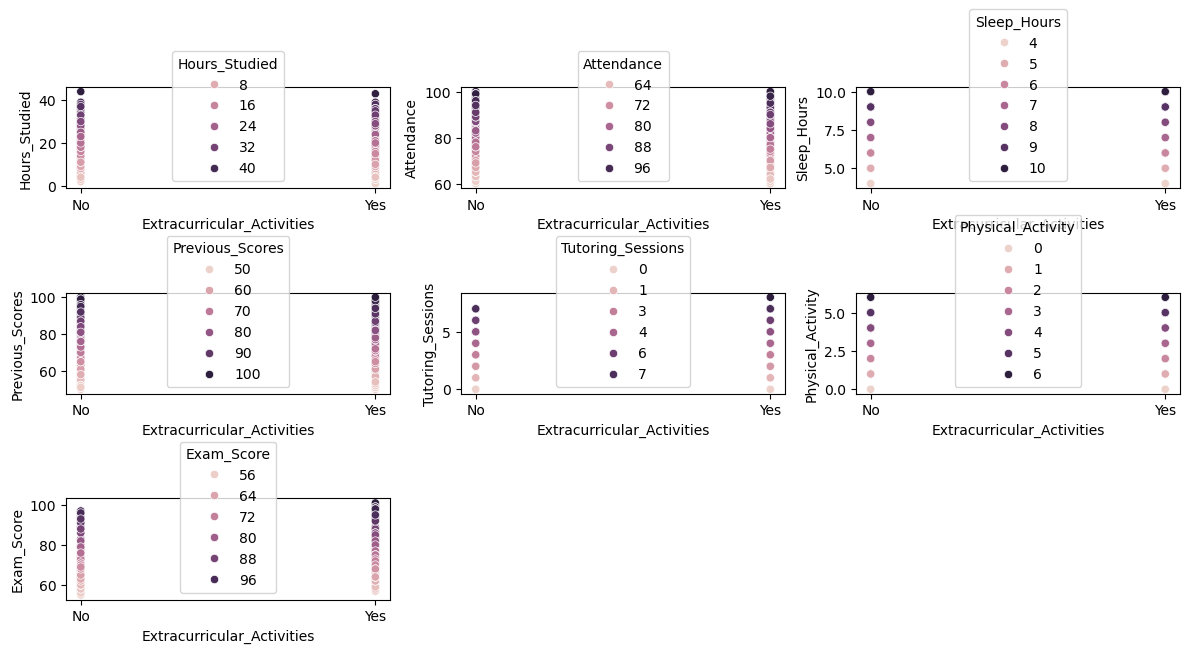

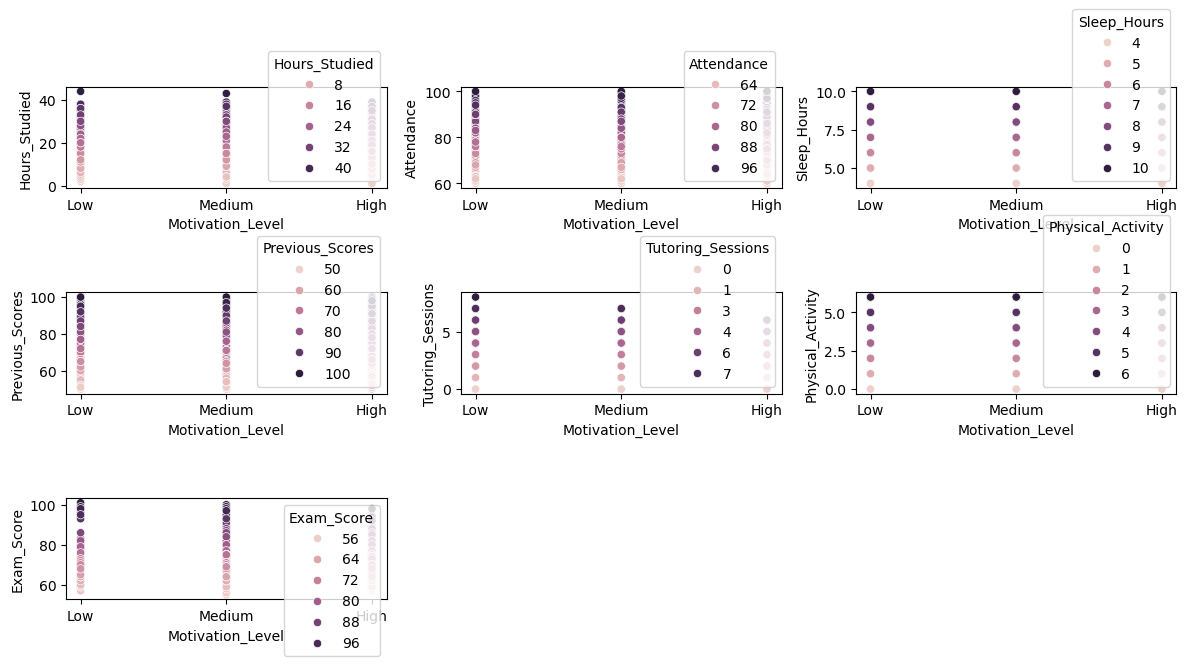

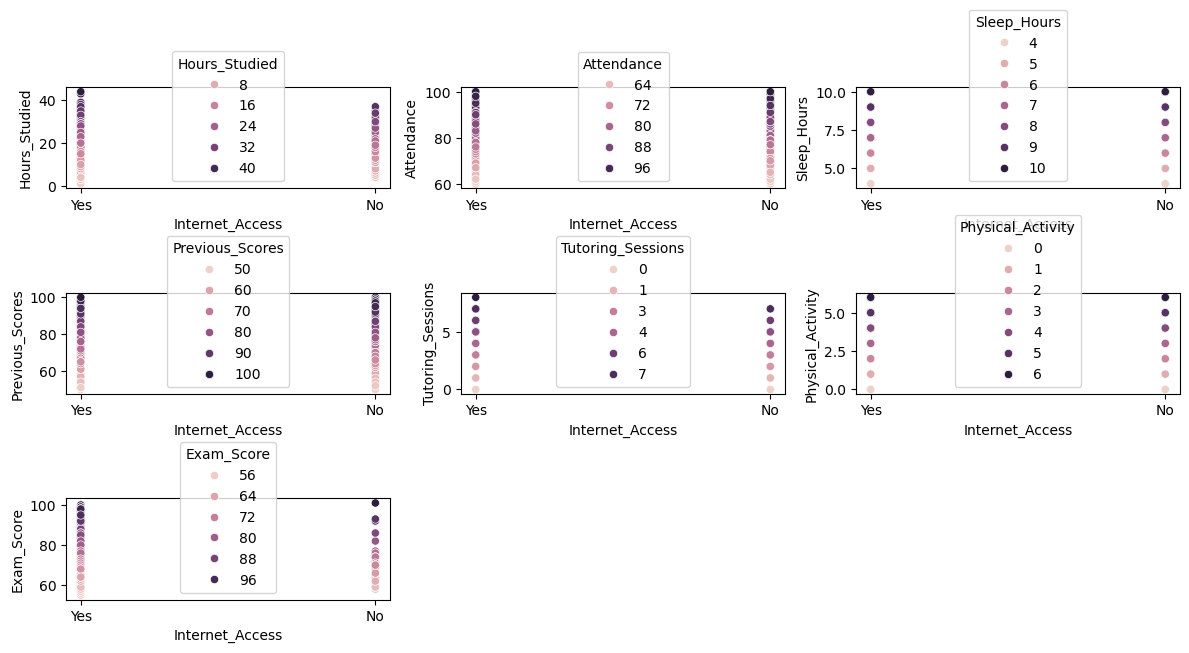

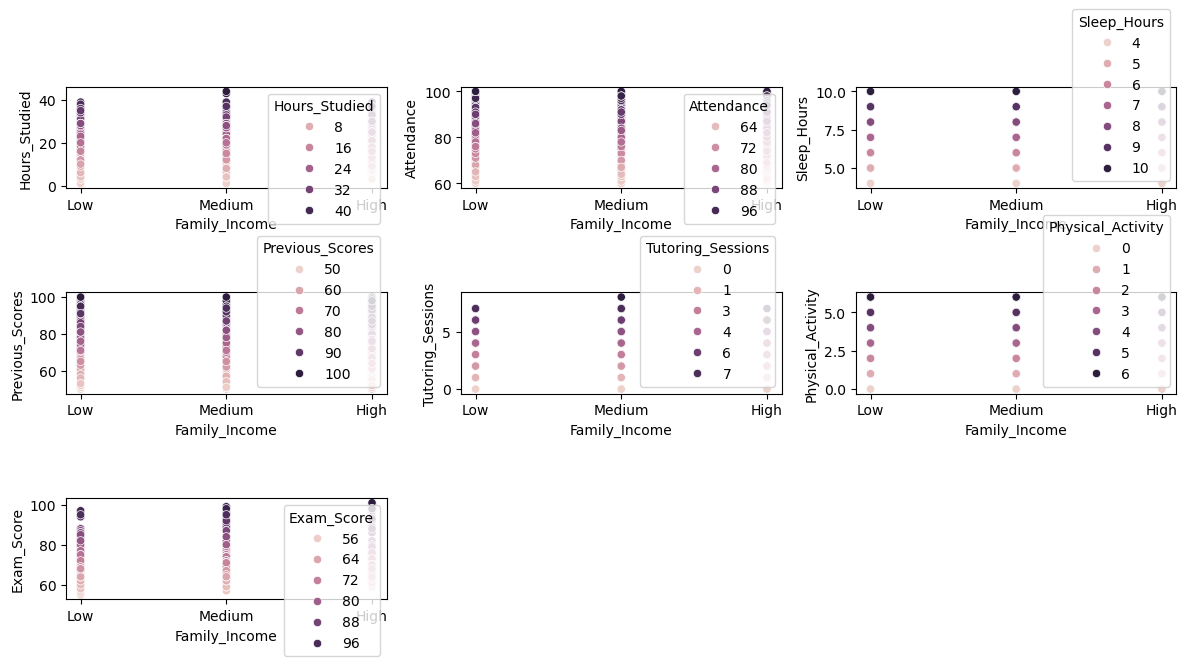

In [15]:
for col in categorical_types.columns:
  scatter_plot(df, numeric_types.columns, col)

<AxesSubplot:xlabel='Attendance', ylabel='Exam_Score'>

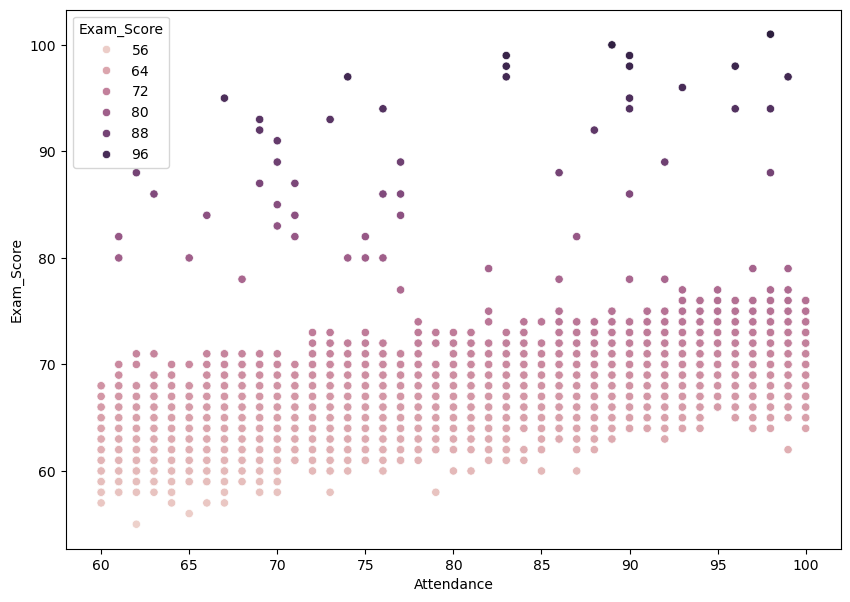

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="Attendance", y="Exam_Score", hue="Exam_Score")

<AxesSubplot:xlabel='Previous_Scores', ylabel='Exam_Score'>

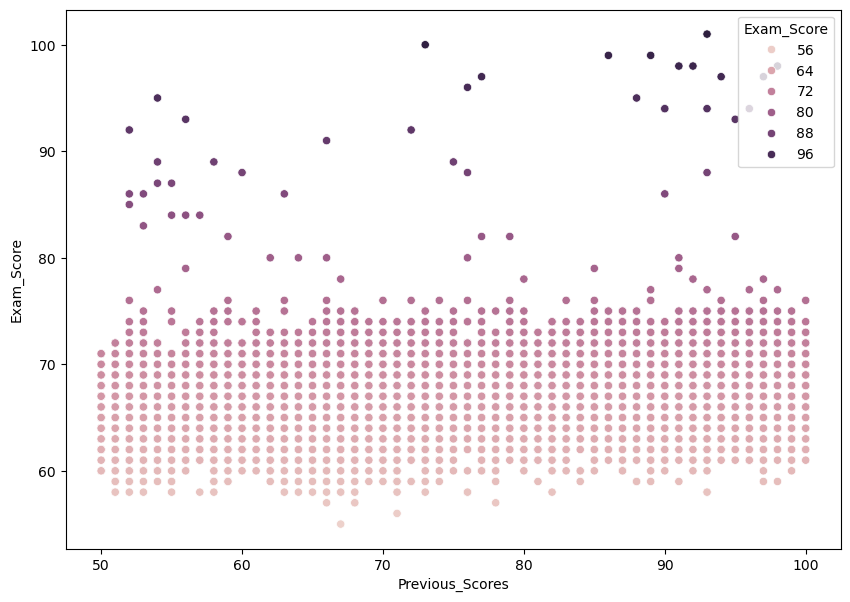

In [ ]:

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="Previous_Scores", y="Exam_Score", hue="Exam_Score")

In [ ]:
numeric_types

Hours_Studied  Attendance  Sleep_Hours  Previous_Scores  \
0                23          84            7               73   
1                19          64            8               59   
2                24          98            7               91   
3                29          89            8               98   
4                19          92            6               65   
...             ...         ...          ...              ...   
6602             25          69            7               76   
6603             23          76            8               81   
6604             20          90            6               65   
6605             10          86            6               91   
6606             15          67            9               94   

      Tutoring_Sessions  Physical_Activity  Exam_Score  
0                     0                  3          67  
1                     2                  4          61  
2                     2                  4          74  
3                     1                  4          71  
4                     3                  4          70  
...                 ...                ...         ...  
6602                  1                  2          68  
6603                  3                  2          69  
6604                  3                  2          68  
6605                  2                  3          68  
6606                  0                  4          64  

[6378 rows x 7 columns]

In [ ]:
numeric_types.drop("Exam_Score", axis=1, inplace=True)

# Preprocessor

In [ ]:
preprocessor = create_preprocessor(numeric_types.columns, categorical_types.columns)
preprocessor

ColumnTransformer(transformers=[('Categorical',
                                 Pipeline(steps=[('Encoder', OneHotEncoder())]),
                                 Index(['Parental_Involvement', 'Access_to_Resources',
       'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access',
       'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence',
       'Learning_Disabilities', 'Parental_Education_Level',
       'Distance_from_Home', 'Gender'],
      dtype='object')),
                                ('Numeric',
                                 Pipeline(steps=[('Scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
       'Tutoring_Sessions', 'Physical_Activity'],
      dtype='object'))])

# Separate Features

In [ ]:
X = df.drop("Exam_Score", axis=1)
y = df["Exam_Score"]

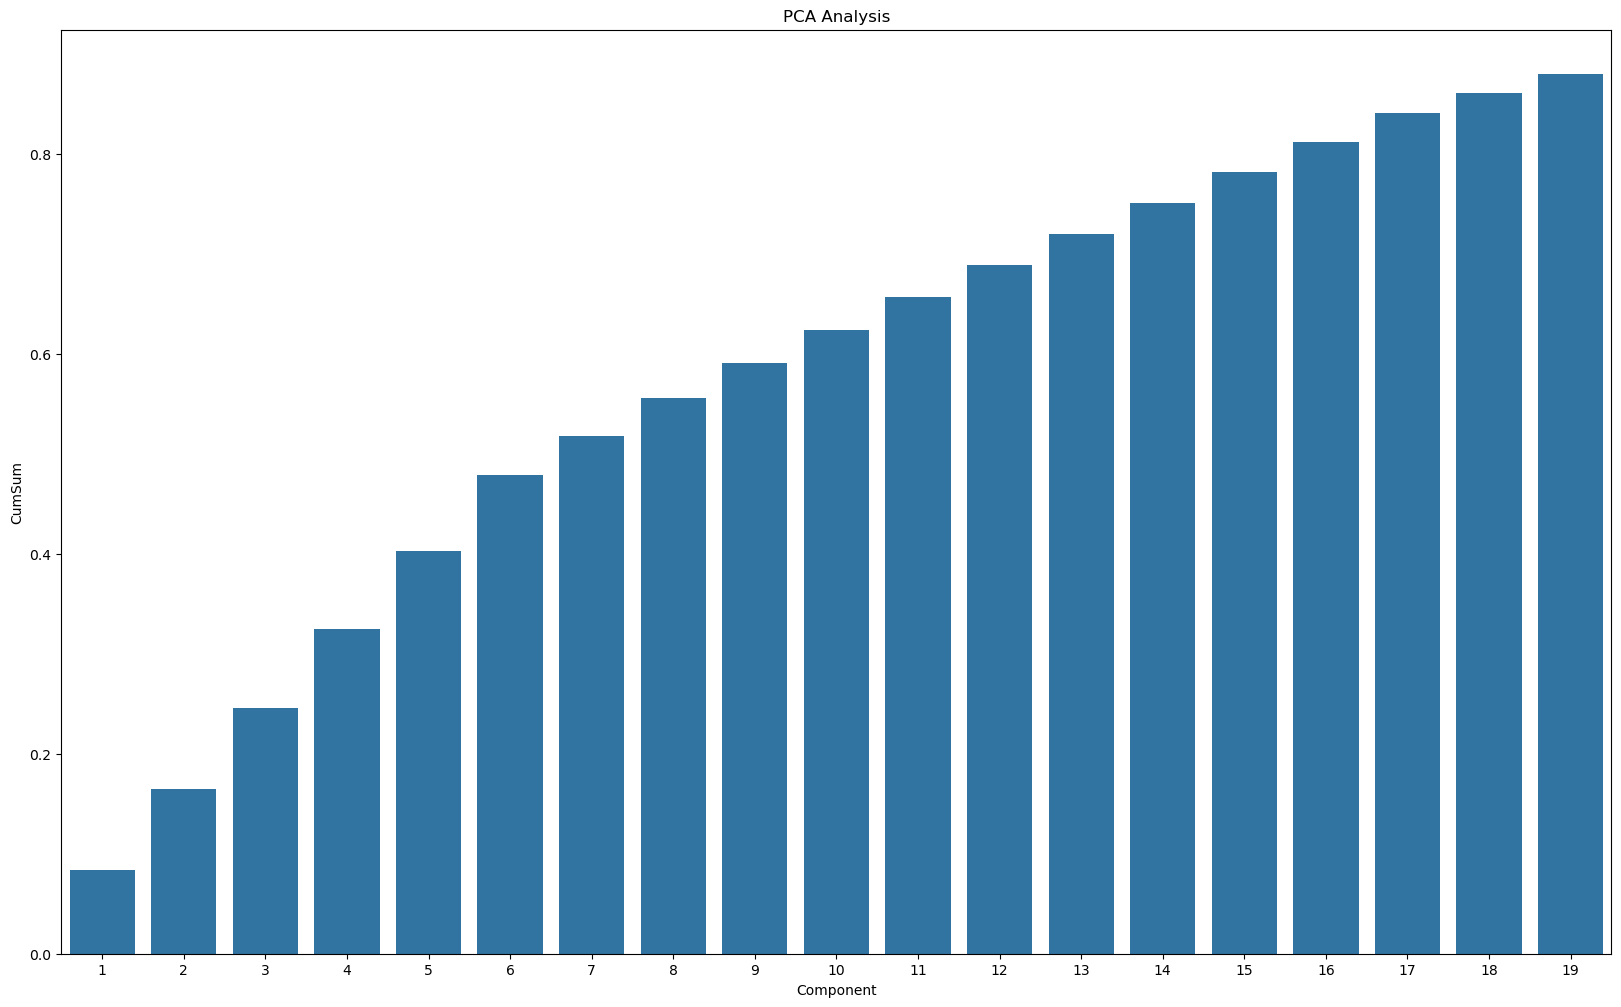

Component    CumSum
0           1  0.083281
1           2  0.165152
2           3  0.245988
3           4  0.325140
4           5  0.402953
5           6  0.478490
6           7  0.517660
7           8  0.556185
8           9  0.590508
9          10  0.624092
10         11  0.656548
11         12  0.688641
12         13  0.719973
13         14  0.750904
14         15  0.781706
15         16  0.811757
16         17  0.841252
17         18  0.861184
18         19  0.880167

In [ ]:
pca_analysis(X, preprocessor)

In [ ]:
MAE = make_scorer(score_func=mean_absolute_error, greater_is_better =False)
MSE = make_scorer(score_func=mean_squared_error, greater_is_better=False)
R2 = make_scorer(score_func=r2_score, greater_is_better=True)
EXP_VAR = make_scorer(score_func=explained_variance_score, greater_is_better=True)

In [ ]:
model_names = ["DUMMY"]
models = get_selected_models(model_names)
test_selected_models(preprocessor, model_names, models, X, y, MSE)

Model    Mean   Var    STD   MAE     MSE   RMSE     R2  Explained Var
0  DUMMY -15.324  4.57  2.138  2.86  15.328  1.979 -0.001         -0.001

In [ ]:
model_names = ["SVR"]
models = get_selected_models(model_names)
kbest = mutual_info_regression
test_kbest_columns(preprocessor, X, y, models[0], model_names[0], kbest)

Model   K       MAE        MSE      RMSE        R2  Explained Var
0    SVR   1  2.102213  10.192581  3.192582  0.343389       0.345523
1    SVR   2  1.546698   7.390129  2.718479  0.523924       0.525277
2    SVR   3  1.443795   6.898919  2.626579  0.555568       0.557740
3    SVR   4  1.446245   6.947746  2.635858  0.552423       0.554722
4    SVR   5  1.263613   6.149917  2.479903  0.603819       0.605188
5    SVR   6  1.315183   6.420167  2.533805  0.586410       0.588416
6    SVR   7  1.323056   6.496352  2.548794  0.581502       0.584867
7    SVR   8  1.286256   6.267404  2.503478  0.596251       0.598959
8    SVR   9  1.314715   6.342736  2.518479  0.591398       0.593237
9    SVR  10  1.233862   6.171559  2.484262  0.602425       0.605516
10   SVR  11  1.032436   5.403829  2.324614  0.651883       0.653912
11   SVR  12  1.180228   5.754020  2.398754  0.629323       0.631041
12   SVR  13  1.113424   5.656394  2.378317  0.635612       0.637685
13   SVR  14  1.066848   5.491173  2.343325  0.646256       0.648434
14   SVR  15  1.060577   5.430485  2.330340  0.650166       0.651612
15   SVR  16  0.985140   5.373489  2.318079  0.653837       0.657252
16   SVR  17  1.024966   5.392986  2.322280  0.652581       0.656069
17   SVR  18  0.927484   5.223611  2.285522  0.663492       0.666605
18   SVR  19  0.826209   4.953933  2.225743  0.680865       0.683108

In [ ]:
kbest = f_regression
test_kbest_columns(preprocessor, X, y, models[0], model_names[0], kbest)

Model   K       MAE        MSE      RMSE        R2  Explained Var
0    SVR   1  2.102213  10.192581  3.192582  0.343389       0.345523
1    SVR   2  1.546698   7.390129  2.718479  0.523924       0.525277
2    SVR   3  1.443795   6.898919  2.626579  0.555568       0.557740
3    SVR   4  1.351433   6.462990  2.542241  0.583651       0.585344
4    SVR   5  1.263613   6.149917  2.479903  0.603819       0.605188
5    SVR   6  1.167846   5.838211  2.416239  0.623900       0.625178
6    SVR   7  1.101685   5.616603  2.369937  0.638176       0.639334
7    SVR   8  1.053746   5.513585  2.348102  0.644812       0.646801
8    SVR   9  1.014611   5.408028  2.325517  0.651612       0.653972
9    SVR  10  0.985342   5.352943  2.313643  0.655161       0.657179
10   SVR  11  0.945546   5.225740  2.285988  0.663355       0.665300
11   SVR  12  0.939780   5.200986  2.280567  0.664950       0.666850
12   SVR  13  0.900786   5.055519  2.248448  0.674321       0.675680
13   SVR  14  0.888144   5.048305  2.246843  0.674786       0.676314
14   SVR  15  0.845030   4.960833  2.227293  0.680421       0.682265
15   SVR  16  0.843190   4.957253  2.226489  0.680651       0.682490
16   SVR  17  0.811094   4.888274  2.210944  0.685095       0.686961
17   SVR  18  0.760691   4.779848  2.186286  0.692080       0.694219
18   SVR  19  0.713275   4.718789  2.172277  0.696013       0.697797

In [ ]:
model_names = ["LR", "SVR", "KNN"]
models = get_selected_models(model_names)
kbest = SelectKBest(score_func=f_regression, k=19)
test_selected_models(preprocessor, model_names, models, X, y, MSE, kbest)

Model   Mean    Var    STD    MAE    MSE   RMSE     R2  Explained Var
0    LR -4.583  4.017  2.004  0.688  4.591  1.464  0.700          0.700
1   SVR -4.660  4.113  2.028  0.705  4.664  1.470  0.696          0.697
2   KNN -6.542  3.973  1.993  1.269  6.533  1.599  0.574          0.574

In [ ]:
model_names = ["XGB", "GBR", "RFR", "LASSO", "RIDGE", "CAT"]
models = get_selected_models(model_names)
test_selected_models(preprocessor, model_names, models, X, y, MSE, kbest)

Model   Mean    Var    STD    MAE    MSE   RMSE     R2  Explained Var
4  RIDGE -4.582  4.017  2.004  0.688  4.591  1.464  0.700          0.700
1    GBR -4.961  3.917  1.979  0.879  4.916  1.489  0.679          0.679
5    CAT -5.051  3.969  1.992  0.829  5.007  1.496  0.673          0.673
2    RFR -5.677  3.754  1.938  1.114  5.705  1.545  0.628          0.628
0    XGB -5.832  3.934  1.983  1.053  5.724  1.547  0.626          0.627
3  LASSO -9.107  4.210  2.052  1.951  9.111  1.737  0.405          0.405

In [ ]:
params = {
  'RIDGE': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    },
    'LASSO': {
        'model__alpha': [0.01, 0.1, 1, 10, 100],
        'model__max_iter': [1000, 5000, 10000]
    },
  
    'DTR': {
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'RFR': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 10, 20],
        'model__min_samples_leaf': [1, 5, 10]
    },
    'GBR': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 4, 6],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto']
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 10, 15],
        'model__weights': ['uniform', 'distance'],
        'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'model__leaf_size': [10, 30, 50],
        'model__p': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0],
        'model__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
        'model__reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
        'model__reg_lambda': [1, 1.5, 2.0]  # L2 regularization term on weights
    },
    'CAT': {
    'model__iterations': [100, 500, 1000, 1500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__depth': [3, 6, 9, 12],
    'model__l2_leaf_reg': [1, 3, 5, 7, 9],
    'model__border_count': [32, 64, 128, 256],
    'model__loss_function': ['RMSE', 'MAE', 'Quantile'],
    'model__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'model__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'model__min_data_in_leaf': [1, 2, 5, 10, 15],
    'model__leaf_estimation_iterations': [1, 5, 10],
    'model__leaf_estimation_method': ['Newton', 'Gradient']
}
}

In [ ]:
model_names = ["XGB", "GBR", "RFR","LASSO", "RIDGE", "KNN", "SVR", "CAT"]
new_models = get_selected_models(model_names)
performance_df, best_models = optimization_search(preprocessor, model_names, new_models, X, y, RandomizedSearchCV, params, MSE, kbest)
performance_df

The Best Param: {'model__subsample': 0.8, 'model__reg_lambda': 1, 'model__reg_alpha': 0.5, 'model__n_estimators': 150, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__gamma': 0.1, 'model__colsample_bytree': 0.8} for Model: XGB
The Best Param: {'model__n_estimators': 100, 'model__min_samples_split': 4, 'model__min_samples_leaf': 2, 'model__max_depth': 3, 'model__learning_rate': 0.2} for Model: GBR
The Best Param: {'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 5, 'model__max_depth': None} for Model: RFR
The Best Param: {'model__max_iter': 10000, 'model__alpha': 0.1} for Model: LASSO
The Best Param: {'model__solver': 'sag', 'model__alpha': 10} for Model: RIDGE
The Best Param: {'model__weights': 'uniform', 'model__p': 2, 'model__n_neighbors': 15, 'model__leaf_size': 50, 'model__algorithm': 'ball_tree'} for Model: KNN


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The Best Param: {'model__kernel': 'linear', 'model__gamma': 'auto', 'model__C': 10} for Model: SVR


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/maukanmir/miniforge3/envs/

The Best Param: {'model__min_data_in_leaf': 5, 'model__loss_function': 'MAE', 'model__learning_rate': 0.2, 'model__leaf_estimation_method': 'Gradient', 'model__leaf_estimation_iterations': 5, 'model__l2_leaf_reg': 5, 'model__iterations': 1000, 'model__grow_policy': 'SymmetricTree', 'model__depth': 6, 'model__border_count': 128, 'model__bootstrap_type': 'MVS'} for Model: CAT


Model       MAE       MSE      RMSE        R2  Explained Var
6    SVR  0.679067  4.694351  2.166645  0.697588       0.699156
4  RIDGE  0.693579  4.701115  2.168205  0.697152       0.697162
7    CAT  0.705094  4.734997  2.176005  0.694969       0.696851
0    XGB  0.869864  5.076966  2.253212  0.672939       0.672974
1    GBR  0.868101  5.079948  2.253874  0.672747       0.672748
3  LASSO  0.985496  5.293445  2.300749  0.658994       0.659009
2    RFR  1.127270  5.684598  2.384240  0.633795       0.633849
5    KNN  1.182169  5.847709  2.418204  0.623288       0.623300

In [ ]:
voting_clf = VotingRegressor(
  estimators=[
    ("svr", best_models[6]),
    ("Ridge", best_models[4]),
    ("CAT", best_models[7]),
    ("XGB", best_models[0]),
    ("GBR", best_models[1])
  ]
)
voting_clf

VotingRegressor(estimators=[('svr',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('Categorical',
                                                                               Pipeline(steps=[('Encoder',
                                                                                                OneHotEncoder())]),
                                                                               Index(['Parental_Involvement', 'Access_to_Resources',
       'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access',
       'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence',
       'Learni...
                                                                                               ('PowerTransformer',
                                                                                                PowerTransformer())]),
                                                                               Index(['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
       'Tutoring_Sessions', 'Physical_Activity'],
      dtype='object'))])),
                                             ('Feature Selection',
                                              SelectKBest(k=19,
                                                          score_func=<function f_regression at 0x338f6caf0>)),
                                             ('model',
                                              GradientBoostingRegressor(learning_rate=0.2,
                                                                        min_samples_leaf=2,
                                                                        min_samples_split=4))]))])

In [ ]:
voting_clf = VotingRegressor(
  estimators=[
    ("svr", best_models[6]),
    ("Ridge", best_models[4]),
    # ("CAT", best_models[7]),
    # ("XGB", best_models[0]),
    # ("GBR", best_models[1])
  ]
)

In [ ]:
voting_regressor(voting_clf, X, y)

Model       MAE       MSE      RMSE        R2  Explained Var
0  voting  0.677965  4.684675  2.164411  0.698211       0.699036

In [ ]:
voting_clf = VotingRegressor(
  estimators=[
    ("svr", best_models[6]),
    # ("Ridge", best_models[4]),
    ("CAT", best_models[7]),
    ("XGB", best_models[0]),
    # ("GBR", best_models[1])
  ]
)

voting_regressor(voting_clf, X, y)

Model       MAE       MSE      RMSE        R2  Explained Var
0  voting  0.706799  4.737529  2.176587  0.694806       0.695683

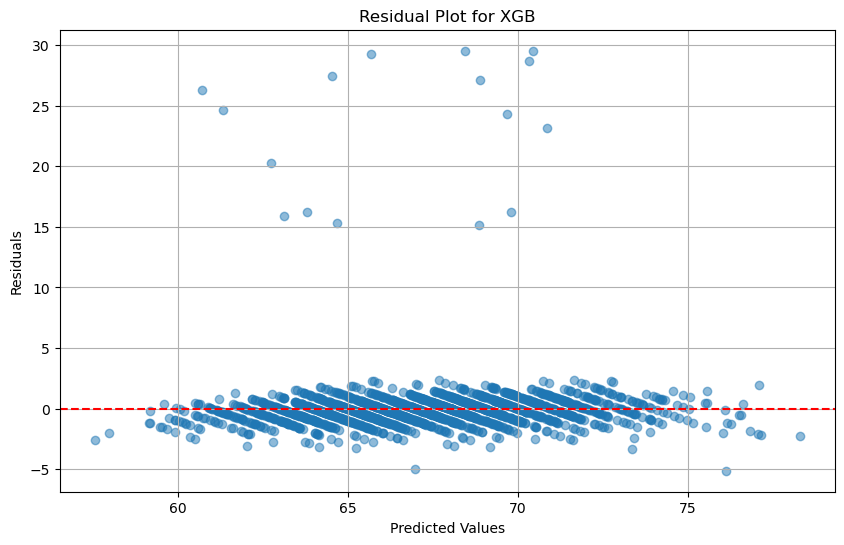

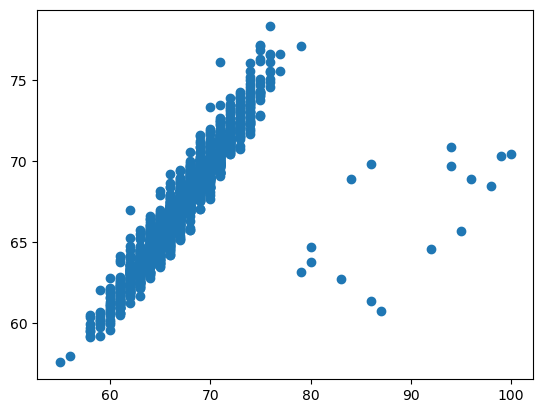

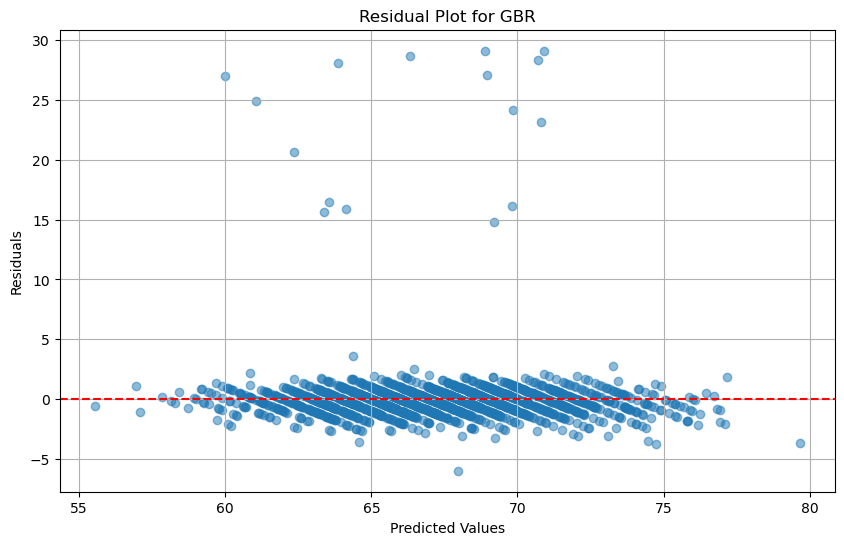

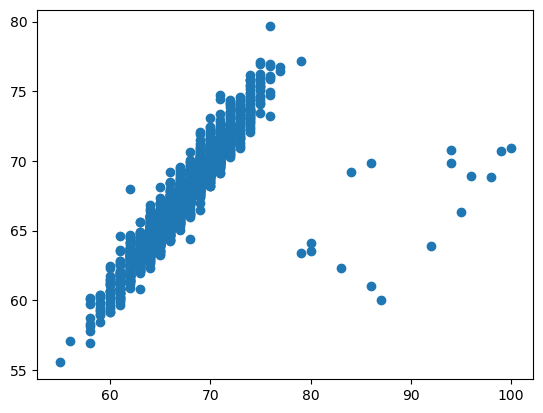

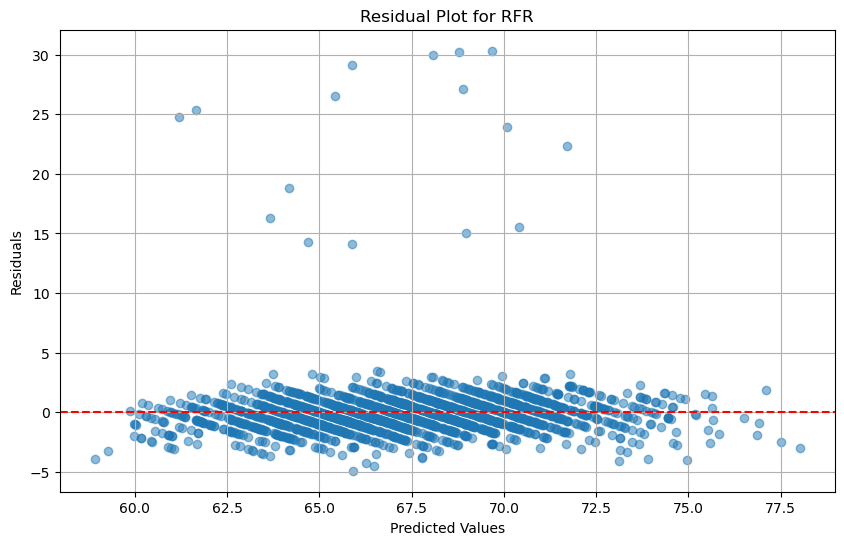

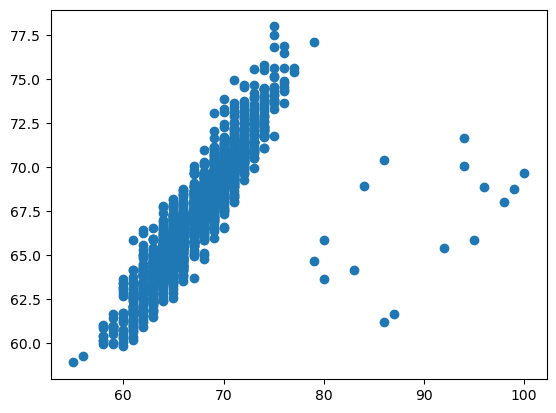

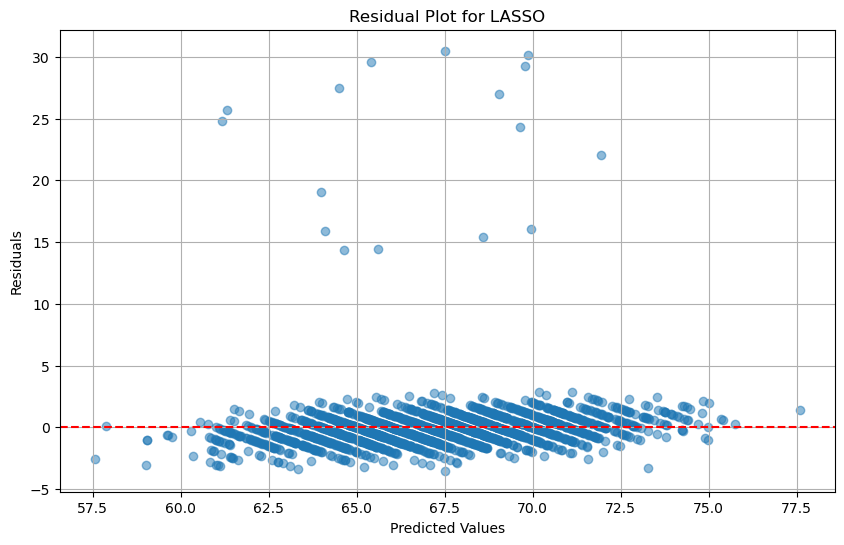

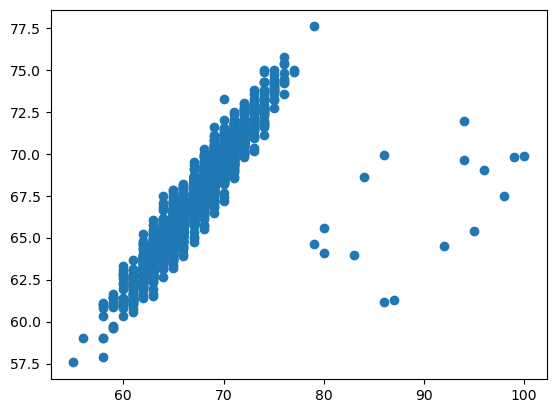

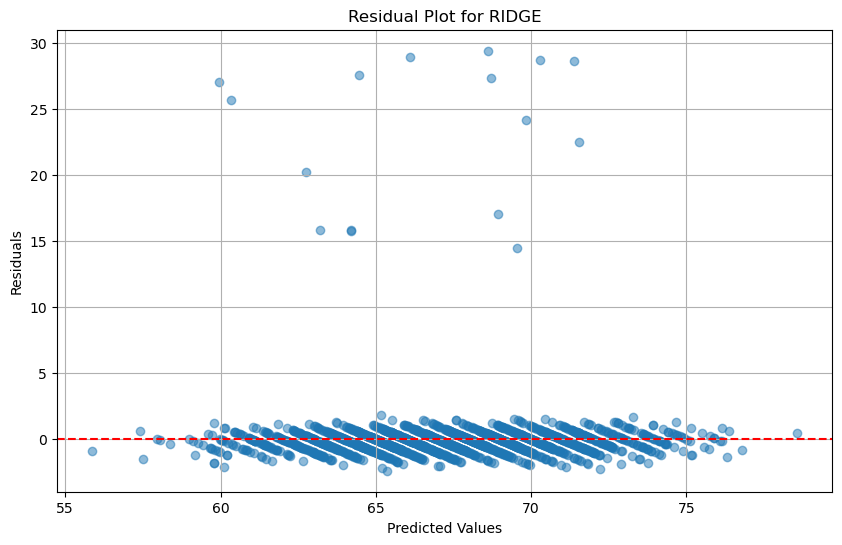

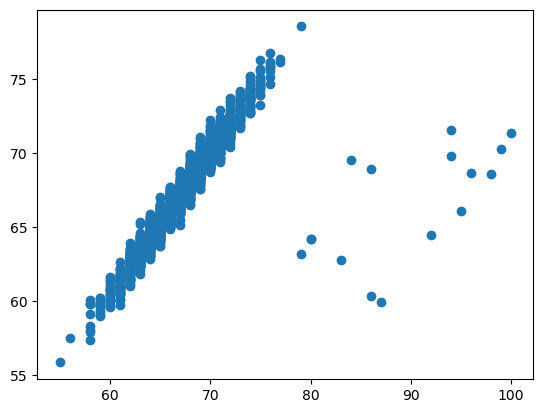

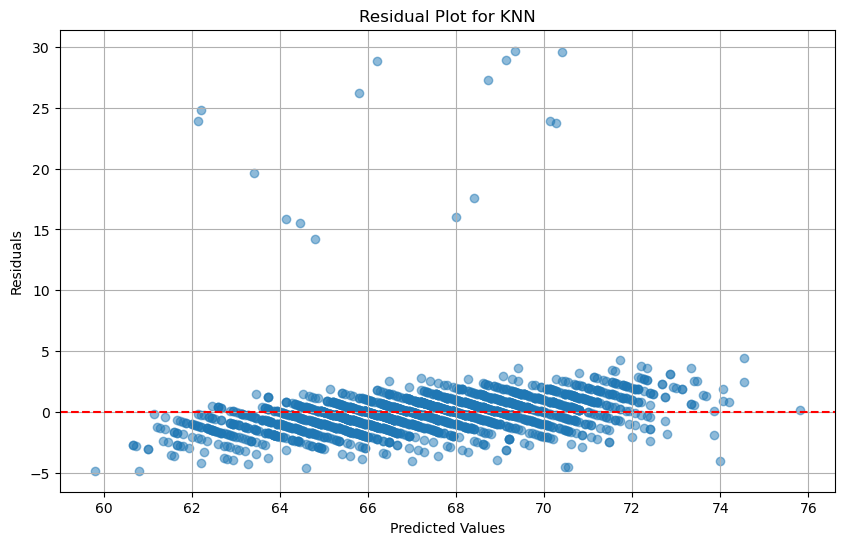

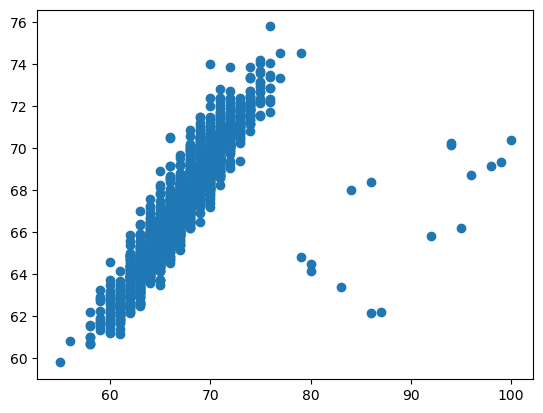

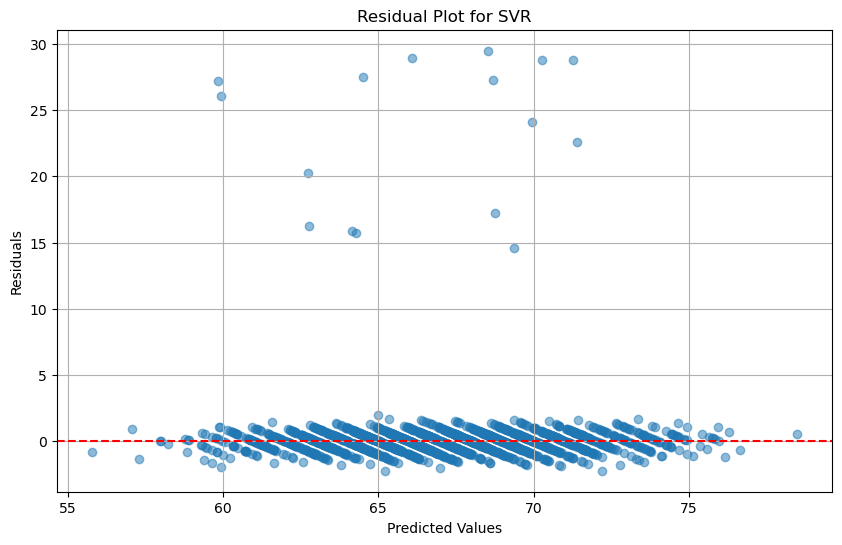

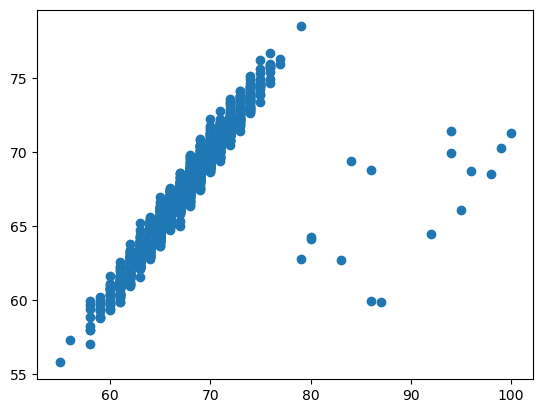

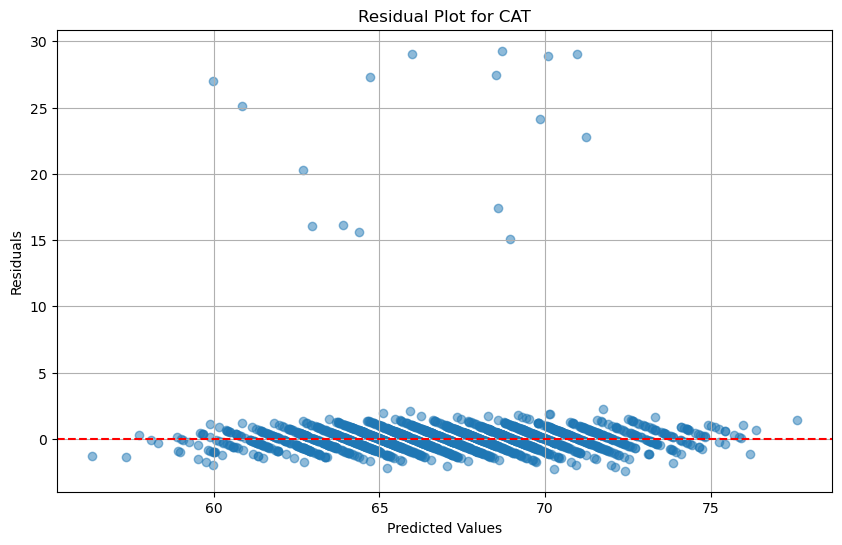

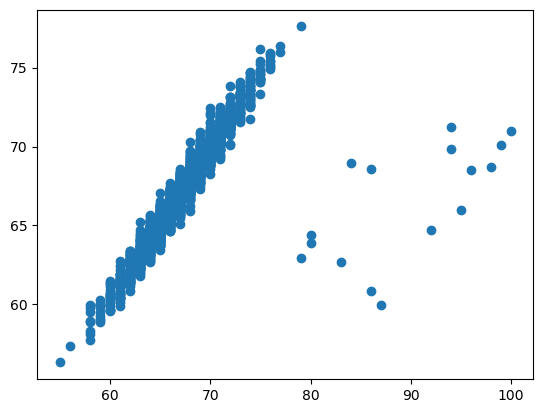

In [ ]:
residual_plot(best_models, model_names, X, y)